# This is a notebook for a node prediction pipeline for the Data distillery knowledge graph

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import polars as pl
import neo4j
from neo4j import GraphDatabase, basic_auth
import random
import numpy as np
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import distinctipy
#from ast import literal_eval
#from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import graphdatascience
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import glob
from matplotlib.lines import Line2D

#import umap
from utils import graph_projections, wcc

'''
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import RandomNodeSplit'''
assert graphdatascience.__version__ == '1.8'

print(sys.version)

3.11.3 (main, Mar  6 2024, 17:13:49) [GCC 11.3.1 20220421 (Red Hat 11.3.1-2)]


#### Important information

If you get jupyter lab errors/warnings such as this:
```
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output to the client in order to avoid crashing it.
To change this limit, set the config variable `--ServerApp.iopub_data_rate_limit`.
Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs) 
```

You can generate a jupyter lab config file
`jupyter lab --generate-config`

and then edit the config parameters with: `vi ~/.jupyter/jupyter_lab_config.py`

# Index

# 1.Preprocessing
1a. Connect to database  
1b. Push properties on Code nodes to Concept nodes. Push Terms to Concept nodes? Run graph algos and mutate?  
1c. Project a subgraph (or query and save the features of a subgraph if its too big to project into memory)  


2a. Or Mutate graph algos as properties here? 
2b. Compute Embeddings based on node properties

Query/return/save? the data for input into a PyG Data Object 


# 1a) Connect to Database and clear previous graphs and properties 

In [2]:
NEO4J_URI=''
NEO4J_USER=''
NEO4J_PASSWORD=''
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")

In [3]:
gds = graphdatascience.GraphDataScience(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD),database=NEO4J_DB)

# Check the installed GDS version on the server
print(f'Python GDS Plugin Version: {graphdatascience.__version__}')
print(f'Neo4j GDS version: {gds.version()}')
assert gds.version() > '2.4'
# Test connection
r=gds.run_cypher('MATCH (N:Concept) RETURN COUNT(DISTINCT N);')
num_total_cuis = r.loc[0][0]
num_total_cuis

Python GDS Plugin Version: 1.8
Neo4j GDS version: 2.6.6


11026102

In [4]:
# LIST PLUGINS / THEIR VERSIONS
print(gds.run_cypher('CALL gds.version();'))
print(gds.run_cypher('RETURN apoc.version();'))

  gdsVersion
0      2.6.6
  apoc.version()
0         5.19.0


In [5]:
print('\nINDEXES:\n------------\n')
gds.run_cypher("""SHOW INDEXES YIELD name, type, labelsOrTypes, properties, options""")


INDEXES:
------------



,name,type,labelsOrTypes,properties,options
0,GeneIndex,VECTOR,[Gene],[term],"{'indexProvider': 'vector-2.0', 'indexConfig':..."
1,GeneIndexC,VECTOR,[Gene],[code_id],"{'indexProvider': 'vector-2.0', 'indexConfig':..."
2,GenePhenotypeMultiIndex,FULLTEXT,[Gene],[code_id],"{'indexProvider': 'fulltext-1.0', 'indexConfig..."
3,GenePhenotypeTask,VECTOR,[Gene],[embedding],"{'indexProvider': 'vector-2.0', 'indexConfig':..."
4,Term_name,FULLTEXT,[Term],[name],"{'indexProvider': 'fulltext-1.0', 'indexConfig..."
5,constraint_2a60667b,RANGE,[Semantic],[TUI],"{'indexProvider': 'range-1.0', 'indexConfig': {}}"
6,constraint_2ad7b311,RANGE,[Term],[SUI],"{'indexProvider': 'range-1.0', 'indexConfig': {}}"
7,constraint_3d19a0e8,RANGE,[Concept],[CUI],"{'indexProvider': 'range-1.0', 'indexConfig': {}}"
8,constraint_49842a42,RANGE,[Code],[CodeID],"{'indexProvider': 'range-1.0', 'indexConfig': {}}"
9,constraint_4a9123bd,RANGE,[NDC],[ATUI],"{'indexProvider': 'range-1.0', 'indexConfig': {}}"


In [ ]:
q="""\
CREATE CONSTRAINT FOR (n:Semantic) REQUIRE n.TUI IS UNIQUE
CREATE CONSTRAINT FOR (n:Semantic) REQUIRE n.STN IS UNIQUE
CREATE CONSTRAINT FOR (n:Semantic) REQUIRE n.DEF IS UNIQUE
CREATE CONSTRAINT FOR (n:Semantic) REQUIRE n.name IS UNIQUE
CREATE CONSTRAINT FOR (n:Concept) REQUIRE n.CUI IS UNIQUE
CREATE CONSTRAINT FOR (n:Code) REQUIRE n.CodeID IS UNIQUE
CREATE INDEX FOR (n:Code) ON (n.SAB)
CREATE INDEX FOR (n:Code) ON (n.CODE)
CREATE CONSTRAINT FOR (n:Term) REQUIRE n.SUI IS UNIQUE
CREATE INDEX FOR (n:Term) ON (n.name)
CREATE CONSTRAINT FOR (n:Definition) REQUIRE n.ATUI IS UNIQUE
CREATE INDEX FOR (n:Definition) ON (n.SAB)
CREATE INDEX FOR (n:Definition) ON (n.DEF)
CREATE CONSTRAINT FOR (n:NDC) REQUIRE n.ATUI IS UNIQUE
CREATE CONSTRAINT FOR (n:NDC) REQUIRE n.NDC IS UNIQUE
CREATE FULLTEXT INDEX Term_name FOR (n:Term) ON EACH [n.name];"""

for query in q.split('\n'):
    r=gds.run_cypher(query)

In [6]:
# check that there are no other graphs projected in-memory
q="""CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount"""

gds.run_cypher(q)

,graphName,nodeCount,relationshipCount


In [7]:
%%time
# remove all Concept properties except for CUIs from previous workflows
# these are properties that I 'pushed' to the concept level
q="""MATCH (n:Concept|UnclassifiedGene)
REMOVE n.SAB
REMOVE n.one_hot_sab
REMOVE n.STY 
REMOVE n.one_hot_sty_label 
REMOVE n.code_id
REMOVE n.term
REMOVE n.SAB_CAT
//REMOVE n.node_label
"""
    
gds.run_cypher(q)

CPU times: user 2.23 ms, sys: 2.21 ms, total: 4.44 ms
Wall time: 6.78 s


""


In [47]:
# Remove extra labels on Concept nodes
# remove all UnclassifiedGene labels and replace them with :Concept
q=f"""MATCH (c:Unclassified) 
SET c:Concept
REMOVE c:UnclassifiedGene
//RETURN COUNT(c)
"""
r=gds.run_cypher(q)
r

""


In [ ]:
%%time
# make sure you've deleted all the old properties except for CUIs on Concepts
q="""MATCH (n:Concept) 
 WITH apoc.coll.flatten(COLLECT(DISTINCT KEYS(n))) as ALL_KEYS
 UNWIND ALL_KEYS AS ALL_KEYS_U
 RETURN COLLECT(DISTINCT ALL_KEYS_U) AS ALL_CUI_PROPS""" # GET ALL IN ONE LIST, DROP DUPS

r=gds.run_cypher(q)['ALL_CUI_PROPS'][0]

print(r)

In [12]:
q="""MATCH (n:Gene) 
 RETURN n LIMIT 1""" # GET ALL IN ONE LIST, DROP DUPS

# //WITH  COLLECT(DISTINCT KEYS(n)) as nd 
r=gds.run_cypher(q)
r

,n
0,"(SAB, SAB_CAT, CUI, code_id)"


# 1b) Execute Cypher that requires the whole graph: Push Code properties and Semantic Type Labels to Concepts

### Push Code properties `SAB` and `CodeID` to Concepts as `SAB` property and as `code_id` property

In [7]:
%%time
query_push_sab="""MATCH (c:Concept)-[:CODE]-(code:Code) 
SET c.SAB = code.SAB
SET c.code_id = code.CodeID;"""
r=gds.run_cypher(query_push_sab)

CPU times: user 7.59 ms, sys: 1.41 ms, total: 8.99 ms
Wall time: 2min 24s


In [5]:
query_push_sab="""MATCH (c:Concept) REMOVE c.SAB_CAT ;"""
r=gds.run_cypher(query_push_sab)

### Change Label of Nodes and set SAB_CAT

In [22]:
%%time

print('Changing "HGNC" node labels to :Gene')
r=gds.run_cypher("""MATCH (c:Concept) WHERE c.SAB = 'HGNC' REMOVE c:Concept SET c:Gene SET c.SAB_CAT=1;""")
r=gds.run_cypher("""MATCH (c:Gene) WHERE c.SAB = 'HGNC' SET c.SAB_CAT=1;""")

print('Changing "HP" node labels to :Phenotype')
r=gds.run_cypher("""MATCH (c:Concept) WHERE c.SAB = 'HP' REMOVE c:Concept SET c:Phenotype SET c.SAB_CAT=2""")

print('Changing "UBERON" node labels to :Tissue')
r=gds.run_cypher("""MATCH (c:Concept) WHERE c.SAB = 'UBERON' REMOVE c:Concept SET c:Tissue SET c.SAB_CAT=3""")

print('Changing "DOID" node labels to :Disease')
r=gds.run_cypher("""MATCH (c:Concept) WHERE c.SAB = 'DOID' REMOVE c:Concept SET c:Disease SET c.SAB_CAT=4""")

print('Changing "CL" node labels to :CellType')
r=gds.run_cypher("""MATCH (c:Concept) WHERE c.SAB = 'CL' REMOVE c:Concept SET c:CellType SET c.SAB_CAT=5""")

r=gds.run_cypher("""MATCH (n) RETURN DISTINCT LABELS(n), COUNT(n)""")
r

Changing "HGNC" node labels to :Gene
Changing "HP" node labels to :Phenotype
Changing "UBERON" node labels to :Tissue
Changing "DOID" node labels to :Disease
Changing "CL" node labels to :CellType
CPU times: user 11.5 ms, sys: 1.65 ms, total: 13.1 ms
Wall time: 31.7 s


,LABELS(n),COUNT(n)
0,[Concept],11026102
1,[Tissue],11517
2,[Disease],2776
3,[CellType],2268
4,[Gene],15667
5,[Phenotype],988
6,[Term],9137251
7,[Code],11995962


In [37]:
r=gds.run_cypher("""MATCH (n) WHERE n:Gene AND n:Concept RETURN DISTINCT LABELS(n), COUNT(n)""")
r

,LABELS(n),COUNT(n)


In [ ]:
r=gds.run_cypher("""MATCH (n) RETURN DISTINCT LABELS(n), COUNT(n)""")
r

In [15]:
r = gds.run_cypher("""MATCH (c) REMOVE c.heart_gene""")
r = gds.run_cypher("""MATCH (c) WHERE  NOT c.heart_gene <> NULL RETURN COUNT(c)""")

q="""MATCH (c:TrainGene|TestGene) WHERE c.heart_gene = 0 SET c.SAB_CAT = 41"""
r=gds.run_cypher(q)
r=gds.run_cypher("""MATCH (c:TrainGene|TestGene) REMOVE c:TrainGene REMOVE c:TestGene SET c:Concept""")

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Query cannot conclude with MATCH (must be a RETURN clause, an update clause, a unit subquery call, or a procedure call with no YIELD) (line 1, column 1 (offset: 0))
"MATCH (c) WHERE NOT c.heart_gene = NULL"
 ^}

#### Create Categorical Labels for HGNC and HPO Concepts (HGNC = 1, HPO = 2). These will be the property we predict (the node classification pipeline didnt work when we tried to predict a property that was a vector).

In [9]:
q="""MATCH (c:Concept) WHERE c.SAB = 'HGNC' SET c.SAB_CAT = 1"""
r=gds.run_cypher(q)

q="""MATCH (c:Concept) WHERE c.SAB = 'HPO' SET c.SAB_CAT = 2"""
r=gds.run_cypher(q)

### Push Semantic Type labels to Concepts as `STY` property

In [11]:
%%time
query_push_all_sty = """MATCH (s:Semantic)-[r:STY]-(c:Gene|Phenotype|Tissue|Disease) SET c.STY = s.name;"""
r=gds.run_cypher(query_push_all_sty)

CPU times: user 3.01 ms, sys: 207 µs, total: 3.22 ms
Wall time: 7.44 s


## Run some queries to check that the properties got moved correctly

In [ ]:
q="""
MATCH (c:Concept) 
WHERE c.SAB IS NOT NULL AND c.SAB IN ['HGNC','HPO'] AND
c.STY IS NOT NULL AND 
c.code_id IS NOT NULL AND 
c.SAB_CAT IS NOT NULL AND
c.term IS NOT NULL
RETURN DISTINCT c.STY //c.SAB, c.STY, c.code_id, c.term LIMIT 5
"""
r=gds.run_cypher(q)
r

In [24]:
%%time
q="""MATCH (c:Concept)-[:CODE]-(code:Code) WHERE c.SAB IS NOT NULL RETURN COUNT( DISTINCT c)"""
r=gds.run_cypher(q)
x=np.round((r.iloc[0][0]/num_total_cuis)*100,2)
print(f'\n{r.iloc[0][0]} Concepts, or {x}% of all Concepts have an SAB property.\n')

q="""MATCH (c:Concept)-[:CODE]-(code:Code)  WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL RETURN COUNT(DISTINCT c)"""
r=gds.run_cypher(q)
x=np.round((r.iloc[0][0]/num_total_cuis)*100,2)
print(f'\n{r.iloc[0][0]} Concepts, or {x}% of all Concepts have an SAB AND a STY (semantic type) property.\n')

10844604 Concepts, or 98.06% of all Concepts have an SAB property.
0 Concepts, or 0.0% of all Concepts have an SAB AND a STY (semantic type) property.
CPU times: user 5.91 ms, sys: 770 µs, total: 6.68 ms
Wall time: 23.5 s


## One hot encode `semantic type node labels` AND `SABs` (Need GDS plugin driver for this)

In [36]:
%%time

query_onehotencode_create = \
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL 
WITH  COLLECT(distinct c.STY) AS distinct_sty, COLLECT(distinct c.SAB) AS distinct_sab
CREATE (:STY_Feature {features: distinct_sty})
CREATE  (:SAB_Feature {features: distinct_sab});"""

query_onehotencode_sty=\
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL  
MATCH (f:STY_Feature) SET c.one_hot_sty_label = gds.alpha.ml.oneHotEncoding(f.features,[c.STY]);"""

query_onehotencode_sab=\
"""MATCH (c:Concept) WHERE c.SAB IS NOT NULL AND c.STY IS NOT NULL  
MATCH (f:SAB_Feature) SET c.one_hot_sab =  gds.alpha.ml.oneHotEncoding(f.features,[c.SAB]);"""

query_onehotencode_delete_sty=""" MATCH (f:STY_Feature) DELETE f;"""

query_onehotencode_delete_sab=""" MATCH (f:SAB_Feature) DELETE f;"""

print('Creating nodes with categories as a property...')
gds.run_cypher(query_onehotencode_create)

print('Creating semantic type one hot encodings...')
gds.run_cypher(query_onehotencode_sty)

print('Creating SAB one hot encodings...')
gds.run_cypher(query_onehotencode_sab)

print('Removing nodes created in first step...')
gds.run_cypher(query_onehotencode_delete_sty)
gds.run_cypher(query_onehotencode_delete_sab)

a=gds.run_cypher("""MATCH (n:STY_Feature) RETURN n""")
b=gds.run_cypher("""MATCH (c:SAB_Feature) RETURN c""")

assert len(a) == 0 and len(b) == 0 # make sure feature nodes are deleted

Creating nodes with categories as a property...
Creating semantic type one hot encodings...
Creating SAB one hot encodings...
Removing nodes created in first step...
CPU times: user 29 ms, sys: 11.5 ms, total: 40.5 ms
Wall time: 3min 18s


# 1c) Project graph in memory

Docs for GDS Python client: https://neo4j.com/docs/graph-data-science-client/current/graph-object/  
We are just using `gds.graph.project()` with a cypher filter statement which is a "cypher projection" so it's technically a `gds.graph.cypher.project()`. But within the cypher projection call we are using a normal projection function.   
For docs on cypher projections see here,  
https://neo4j.com/docs/graph-data-science/current/management-ops/graph-creation/graph-project-cypher-projection/  
The cypher projection syntax is everything in the Tripled quotes, the additional parameters are part of the graph data. Science python client function.


In [9]:
# check that there are no other graphs projected in-memory
q="""CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount"""

gds.run_cypher(q)

In [7]:
# drop all previous graphs, if they exist
for GRAPH in ['newG','graph_from_df','f-graph','largest_connected_components']:
    if gds.graph.exists(GRAPH)['exists']:
        G = gds.graph.get(GRAPH)
        print(f'Dropping {GRAPH}...')
        G.drop()

# Use a Cypher Projection
"CALL gds.graph.project.cypher($graph_name, $node_spec, $relationship_spec, $config)"  
Add 2-hop neighborhood...

In [8]:
result, G = graph_projections.make_llm_subgraph(gds)

In [10]:
query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",["SAB_CAT"],{G.node_labels()},{{ listNodeLabels: true }})
YIELD nodeId, nodeLabels, nodeProperty, propertyValue
RETURN nodeId, nodeLabels, nodeProperty, propertyValue"""

a = gds.run_cypher(query_get_props)
a['nodeLabels'] = [i[0] for i in a['nodeLabels']]
Counter(a['nodeLabels'])

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.nodeProperties.stream`: Caused by: java.lang.IllegalArgumentException: Expecting all specified node projections to have all given properties defined. Could not find property key(s) ['SAB_CAT'] for label Phenotype. Defined keys: [].}

In [11]:
print(f'Node count: {G.node_count()}')
print(f'Node labels: {G.node_labels()}')
print(f'Node Properties: {G.node_properties()}')
print(f'Relationship count: {G.relationship_count()}')
print(f'Relationship types: {G.relationship_types()}')
#print(f'Memory Usage: {G.memory_usage()}')
#relationship_properties #degree_distribution #density #configuration #creation_time #modification_time
# CALL gds.config.defaults.list({ username: 'Alicia', key: 'concurrency' })

Node count: 15262
Node labels: ['Phenotype', 'Disease', 'Gene', 'Tissue']
Node Properties: Phenotype    []
Disease      []
Gene         []
Tissue       []
dtype: object
Relationship count: 187264
Relationship types: ['channels_into', 'is_not_primary_anatomic_site_of_disease', 'distalmost_part_of', 'develops_in', 'has_origin', 'occurs_in', 'has_regional_part', 'disease_has_location', 'is_grade_of_disease', 'part_of', 'derives_from', 'has_finding_site', 'has_muscle_insertion', 'location_of', 'direct_right_of', 'contains_process', 'in_lateral_side_of', 'has_disease_location', 'supplies', 'has_manifestation', 'immediately_posterior_to', 'CHD', 'ends', 'in_posterior_side_of', 'gene_associated_with_disease_or_phenotype', 'developmentally_induces', 'has_tributary', 'develops_from_part_of', 'dorsal_to', 'drains_into', 'same_as', 'develops_from', 'associated_with', 'has_material_basis_in_germline_mutation_in', 'develops_into', 'connected_to', 'attached_to', 'has_part', 'has_component', 'disease

### Look at the topology of the subgraph (sourceID,relType,targetID)- and get the node properties so we can see which relationships are the most frequent. This way we can filter out relationships that are unneeded but very frequent

In [ ]:
q=f"""CALL gds.graph.relationships.stream("{G.name()}")
YIELD sourceNodeId, targetNodeId, relationshipType
RETURN sourceNodeId, targetNodeId, relationshipType ORDER BY sourceNodeId ASC, targetNodeId ASC"""

topology=gds.run_cypher(q)
topology['rel_map'] = [str(i)+'_'+str(j) for i,j in zip(topology['sourceNodeId'],topology['targetNodeId'])]
#topology 

query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",["SAB_CAT"],{G.node_labels()},{{ listNodeLabels: true }})
YIELD nodeId, nodeLabels, nodeProperty, propertyValue
RETURN nodeId, nodeLabels, nodeProperty, propertyValue"""

top_prop_map = gds.run_cypher(query_get_props)
top_prop_map['nodeLabels'] = [i[0] for i in top_prop_map['nodeLabels']]
#top_prop_map

source_top = pd.merge(topology[['rel_map','sourceNodeId','relationshipType']],
                         top_prop_map[['nodeId','propertyValue']], 
                         left_on='sourceNodeId',right_on='nodeId')\
                    .rename(columns={'propertyValue':'sourceSAB'})\
                    .drop(['nodeId','sourceNodeId','relationshipType'],axis=1)
#source_top.head(3)

target_top = pd.merge(topology[['rel_map','targetNodeId','relationshipType']],
                         top_prop_map[['nodeId','propertyValue']], 
                         left_on='targetNodeId',right_on='nodeId')\
                        .rename(columns={'propertyValue':'targetSAB'})\
                            .drop(['nodeId','targetNodeId'],axis=1)
#target_top.head(3)
top_map_sab = pd.merge(source_top,target_top,on='rel_map')\
                    .drop('rel_map',axis=1)[['sourceSAB','relationshipType','targetSAB']]
                    
#top_map_sab

top_map_sab = top_map_sab.replace(to_replace=1,value='HGNC')
top_map_sab = top_map_sab.replace(to_replace=2,value='HP')
top_map_sab = top_map_sab.replace(to_replace=4,value='DOID')

top_map_sab['srt'] = [str(i)+'----'+str(j)+'-----'+str(k) for i,j,k in zip(top_map_sab['sourceSAB'],
                                                     top_map_sab['relationshipType'],
                                                     top_map_sab['targetSAB'])]

Counter(top_map_sab['srt']).most_common()

In [56]:
r=gds.run_cypher("""MATCH (n) RETURN DISTINCT LABELS(n), COUNT(n)""")
r

,LABELS(n),COUNT(n)
0,[Concept],11026102
1,[Tissue],11517
2,[Disease],2776
3,[CellType],2268
4,[Gene],15667
5,[Phenotype],988
6,[Term],9137251
7,[Code],11995962


In [21]:
%%capture
'''GRAPH_NAME='newG'
# LABELS(source) IN ['Concept','UnclassifiedGene'] AND LABELS(target) IN ['Concept','UnclassifiedGene'] 

q=f"""MATCH (source:Concept|UnclassifiedGene)-[r]-(target:Concept|UnclassifiedGene) 
WHERE type(r) IN ['associated_with','gene_associated_with_disease_or_phenotype'] AND
source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO'] AND source.SAB_CAT IN [1,2] AND target.SAB_CAT IN [1,2]
WITH gds.graph.project('{GRAPH_NAME}',source,target,
  {{
    sourceNodeLabels: ['UnclassifiedGene','Concept'],//labels(source),
    targetNodeLabels: ['UnclassifiedGene','Concept'],//labels(target),
    relationshipType: type(r),
    sourceNodeProperties: source {{ SAB_CAT:  coalesce(source.SAB_CAT, -1), one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(source.one_hot_sty_label, [0]) }},
    targetNodeProperties: target {{ SAB_CAT: coalesce(target.SAB_CAT, -1),  one_hot_sty_label: coalesce(target.one_hot_sty_label, [0]) }}
  }}) AS g        // 
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
"""
G = gds.graph.get(GRAPH_NAME)
r=gds.run_cypher(q)'''

,graph,nodes,rels
0,newG,5098,148698


In [7]:
%%capture
'''
%%time
GRAPH_NAME='newG'

# LABELS(source) IN ['Concept','UnclassifiedGene'] AND LABELS(target) IN ['Concept','UnclassifiedGene'] 

q=f"""
MATCH (source:Concept)-[r]-(T:Concept) 
MATCH (T)-[x]-(target:UnclassifiedGene) 
WHERE type(r) IN ['associated_with','gene_associated_with_disease_or_phenotype'] AND
source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO'] AND T.SAB IN ['HGNC','HPO'] 
WITH gds.graph.project('{GRAPH_NAME}',source,target,
  {{
    sourceNodeLabels: ['UnclassifiedGene','Concept'],//labels(source),
    targetNodeLabels: ['UnclassifiedGene','Concept'],//labels(target),
    relationshipType: type(r),
    sourceNodeProperties: source {{ one_hot_sab: coalesce(source.one_hot_sab, [0]), one_hot_sty_label: coalesce(source.one_hot_sty_label, [0]) }},
    targetNodeProperties: target {{ one_hot_sty_label: coalesce(target.one_hot_sty_label, [0]) }}
  }}) AS g        // one_hot_sab: coalesce(target.one_hot_sab, [0]), 
RETURN g.graphName AS graph, g.nodeCount AS nodes, g.relationshipCount AS rels
"""

G = gds.graph.get(GRAPH_NAME)
r=gds.run_cypher(q)
r'''

In [13]:
# get id and props from main graph for mapping string properties later
q="""
MATCH (source:Concept)-[r]-(target:Concept) 
WHERE type(r) IN ['associated_with','gene_associated_with_disease_or_phenotype'] AND
source.SAB IN ['HGNC','HPO'] AND target.SAB IN ['HGNC','HPO']
RETURN DISTINCT id(source) as nodeId, labels(source) AS nodeLabels, source.STY as STY, 
source.SAB as SAB, source.code_id as codeID, source.term as term, source.SAB_CAT AS SAB_CAT
"""
r=gds.run_cypher(q)
ids = np.unique(r['nodeId'])

df_map = r
df_map.index = df_map['nodeId']
print(Counter([i[0] for i in df_map['nodeLabels']]))
df_map.head(5)

Counter({'Concept': 5098})


,nodeId,nodeLabels,STY,SAB,codeID,term,SAB_CAT
nodeId,,,,,,,
87,87,[Concept],Disease or Syndrome,HPO,HPO:0000490,enophthalmos,2
7210,7210,[Concept],Gene or Genome,HGNC,HGNC:30935,YY1 ASSOCIATED PROTEIN 1,1
7213,7213,[Concept],Gene or Genome,HGNC,HGNC:10549,ataxin 10,1
10259,10259,[Concept],Anatomical Abnormality,HPO,HPO:0011328,Abnormality of fontanelles,2
10260,10260,[Concept],Anatomical Abnormality,HPO,HPO:0100491,Abnormality of lower limb joint,2


## Recreate projected graph from Dataframe

In [20]:
G = gds.graph.construct(
    "graph_from_df",      # Graph name
    nodes_df_merge,           # One or more dataframes containing node data
    rels_df    # One or more dataframes containing relationship data
)

In [21]:
print(f'Node count: {G.node_count()}')
print(f'Node labels: {G.node_labels()}')
print(f'Node Properties: {G.node_properties()}')
print(f'Relationship count: {G.relationship_count()}')
print(f'Relationship types: {G.relationship_types()}')
print(f'Memory Usage: {G.memory_usage()}')

Node count: 5098
Node labels: ['Unknown', '__ALL__', 'Concept']
Node Properties: Unknown    [SAB_CAT, one_hot_sab]
__ALL__                        []
Concept    [SAB_CAT, one_hot_sab]
dtype: object
Relationship count: 148698
Relationship types: ['gene_associated_with_disease_or_phenotype', 'associated_with']
Memory Usage: 10681 KiB


In [22]:
q=f"""CALL gds.graph.filter('f-graph','{G.name()}','n:Concept OR n:Unknown','*')
YIELD graphName, fromGraphName, nodeCount, relationshipCount """
res=gds.run_cypher(q)
G = gds.graph.get('f-graph')
res

,graphName,fromGraphName,nodeCount,relationshipCount
0,f-graph,graph_from_df,2241,40180


In [21]:
query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",['one_hot_sab','SAB_CAT'],['Concept','Unknown'],{{ listNodeLabels: true }})
YIELD
    nodeId, nodeLabels, nodeProperty, propertyValue
    RETURN nodeLabels, nodeId, nodeProperty, propertyValue"""

res = gds.run_cypher(query_get_props); res.head(3)

,nodeLabels,nodeId,nodeProperty,propertyValue
0,[Concept],7210,one_hot_sab,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[Concept],7210,SAB_CAT,1
2,[Concept],7213,one_hot_sab,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## 1d) Use Weakly Connected Components to find # of components in projected graph

In [9]:
G = wcc.weakly_connected_components(gds,G)
print(f'New fully connected graph name is:  {G.name()}')

Components found: 428
The largest component has the id 0 with 14041 nodes.
New fully connected graph name is:  largest_connected_components


In [83]:
query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",["SAB_CAT"],{G.node_labels()},{{ listNodeLabels: true }})
YIELD nodeId, nodeLabels, nodeProperty, propertyValue
RETURN nodeId, nodeLabels, nodeProperty, propertyValue"""

a = gds.run_cypher(query_get_props)
a['nodeLabels'] = [i[0] for i in a['nodeLabels']]
Counter(a['nodeLabels'])

Counter({'Tissue': 10517, 'Disease': 1732, 'Gene': 1300, 'Phenotype': 492})

In [84]:
query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",["SAB_CAT"],{G.node_labels()},{{ listNodeLabels: true }})
YIELD nodeId, nodeLabels, nodeProperty, propertyValue
RETURN nodeId, nodeLabels, nodeProperty, propertyValue"""

a = gds.run_cypher(query_get_props)
a['nodeLabels'] = [i[0] for i in a['nodeLabels']]
Counter(a['nodeLabels'])

Counter({'Tissue': 10517, 'Disease': 1732, 'Gene': 1300, 'Phenotype': 492})

#### Need to export subgraph projection for use with an LLM and RAG application
APOC Export to cypher script Docs: https://neo4j.com/labs/apoc/4.3/export/cypher/

Options for using `apoc.export.cypher.*` are:  
- export whole database, `apoc.export.cypher.all()`  
- export specified nodes/edges, `apoc.export.cypher.data()`  
- export a graph object, `apoc.export.cypher.graph()`   (must define within same query though...)  

Same options are available for saving to CSV file(s) with `apoc.export.csv.*`
- export whole database, `apoc.export.csv.all()`  
- export specified nodes/edges, `apoc.export.csv.data()`  
- export a graph object, `apoc.export.csv.graph()`   


# Use apoc.export.cypher.* to export data as a cypher script

# 2a) Run graph algos and mutate nodes with results (or if using millions of nodes, just stream results and nodeIds) 

(or at least a larger part than what we want to project, ie if we want to include all gene/phenotype Concept nodes and any nodes that are within 3 hops of any of those nodes for running the algorithm, but we only want the actual gene/phenotype nodes for the graph projection)  
In the case when you have a graph that does not have node properties we recommend to use existing algorithm in mutate mode to create node properties. Good candidates are Centrality algorithms or Community algorithms.  
Run Centrality and Community algorithms to create properties, if we don't have any node properties. Or maybe run this in the full graph first?  
What about graph algos that take relationship type into account??

In [8]:
# Create property list and add property after each algo score to the list if its been 
# successfully mutated onto the projected graph.

props = set()

## Centrality Algorithms

### Degree Centrality

In [9]:
%%time

if 'degreeCentrality' not in G.node_properties()[0]: 
    
    degree_centrality_result = gds.degree.mutate(G, mutateProperty="degreeCentrality")

    props.add('degreeCentrality')
    
    print(degree_centrality_result)

nodePropertiesWritten                                                  2428
mutateMillis                                                              0
centralityDistribution    {'min': 1.0, 'max': 94.00048065185547, 'p90': ...
postProcessingMillis                                                      0
preProcessingMillis                                                       0
computeMillis                                                             2
configuration             {'orientation': 'NATURAL', 'mutateProperty': '...
Name: 0, dtype: object
CPU times: user 6.59 ms, sys: 0 ns, total: 6.59 ms
Wall time: 183 ms


In [ ]:
# Drop old non-scaled properties
q=f"""CALL gds.graph.nodeProperties.drop('{G.name()}', ['pageRankScore']) YIELD propertiesRemoved"""
gds.run_cypher(q)

### Page Rank

In [10]:
%%time 

if 'pageRankScore' not in G.node_properties()[0]: 
    
    page_rank_result = gds.pageRank.mutate(G,mutateProperty="pageRankScore",maxIterations=160,dampingFactor=0.85)

    props.add('pageRankScore')

    print(page_rank_result)

mutateMillis                                                              0
nodePropertiesWritten                                                  2428
ranIterations                                                            93
didConverge                                                            True
centralityDistribution    {'min': 0.20557403564453125, 'max': 11.3301992...
postProcessingMillis                                                     29
preProcessingMillis                                                       0
computeMillis                                                           306
configuration             {'mutateProperty': 'pageRankScore', 'jobId': '...
Name: 0, dtype: object
CPU times: user 6.74 ms, sys: 0 ns, total: 6.74 ms
Wall time: 400 ms


### Eigenvector Centrality

In [36]:
eigenvector_centrality_result = gds.eigenvector.mutate(G, 
                                    maxIterations=100, 
                                    mutateProperty="eigenvectorCentrality")

if 'eigenvectorCentrality' in G.node_properties()[0]: props.add('eigenvectorCentrality')
    
#eigenvector_centrality_result

### Betweenness Centrality

In [31]:

if 'betweennessCentrality' not in G.node_properties()[0]:
    
    betweenness_centrality_result = gds.betweenness.mutate(G, mutateProperty="betweennessCentrality")

    props.add('betweennessCentrality')

    print(betweenness_centrality_result)

BetweennessCentrality: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:00<00:00, 251.06%/s]

nodePropertiesWritten                                                  2172
mutateMillis                                                              0
centralityDistribution    {'min': 0.0, 'max': 668539.9999995232, 'p90': ...
postProcessingMillis                                                    140
preProcessingMillis                                                       0
computeMillis                                                           754
configuration             {'mutateProperty': 'betweennessCentrality', 'j...
Name: 0, dtype: object


### Article Rank
https://neo4j.com/docs/graph-data-science/current/algorithms/article-rank/#algorithms-article-rank-syntax

In [49]:

if 'articleRankScore' not in G.node_properties()[0]:
    
    articleRank_result = gds.articleRank.mutate(G, mutateProperty='articleRankScore')

    props.add('articleRankScore')

    print(articleRank_result)

mutateMillis                                                              0
nodePropertiesWritten                                                  2182
ranIterations                                                            20
didConverge                                                           False
centralityDistribution    {'min': 0.1545724868774414, 'max': 4.733122825...
postProcessingMillis                                                     19
preProcessingMillis                                                       0
computeMillis                                                            85
configuration             {'mutateProperty': 'articleRankScore', 'jobId'...
Name: 0, dtype: object


### CELF
https://neo4j.com/docs/graph-data-science/current/algorithms/celf/#alpha-algorithms-celf-examples-mutate

In [39]:
query_celf=\
f"""
CALL gds.influenceMaximization.celf.mutate(, {{
  mutateProperty: 'celfSpread',
  seedSetSize: 3
}})
YIELD nodePropertiesWritten
"""

celf_result = gds.run_cypher(query_celf)

assert 'celfSpread' in G.node_properties()[0]

celf_result

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Type mismatch: expected String but was Map (line 2, column 46 (offset: 46))
"CALL gds.influenceMaximization.celf.mutate(, {"
                                              ^}

## Community Detection Algorithms -- need to one-hot encode the cluster IDs here

In [57]:
# create a new empty set to keep track of the community detection algorithms
community_props = set()

https://neo4j.com/docs/graph-data-science/current/algorithms/community/

### Louvain Community Detection

In [1]:
%%time

if 'louvainCommunityId' not in G.node_properties()[0]:
    
    lovain_result = gds.louvain.mutate(G, mutateProperty='louvainCommunityId')

    community_props.add('louvainCommunityId')

    print(lovain_result)

NameError: name 'G' is not defined

### Leiden Community Detection -- WORKS ONLY FOR UNDIRECTED GRAPHS, need to mutate edges to be undirected 

In [27]:
%%time

if 'leidenCommunityId' not in G.node_properties()[0]: 
    
    leiden_results = gds.leiden.mutate(G, mutateProperty="leidenCommunityId")
    
    community_props.add('leidenCommunityId')
    
    print(leiden_results) 

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.leiden.mutate`: Caused by: java.lang.IllegalArgumentException: The Leiden algorithm works only with undirected graphs. Please orient the edges properly}

### Label Propagation 

In [33]:
%%time

if 'lpaCommunityId' not in G.node_properties()[0]: 
    
    lpa_results = gds.labelPropagation.mutate(G, mutateProperty="lpaCommunityId")
    
    community_props.add('lpaCommunityId')
    
print(lpa_results)

mutateMillis                                                             0
nodePropertiesWritten                                                 2197
ranIterations                                                            5
didConverge                                                           True
communityCount                                                           3
communityDistribution    {'min': 3, 'p5': 3, 'max': 2190, 'p999': 2190,...
postProcessingMillis                                                    10
preProcessingMillis                                                      0
computeMillis                                                           38
configuration            {'nodeWeightProperty': None, 'mutateProperty':...
Name: 0, dtype: object
CPU times: user 6.96 ms, sys: 1.37 ms, total: 8.34 ms
Wall time: 105 ms


### Change graph relationships from directed to undirected
- must provide relationship type

In [ ]:
und_results = gds.graph.relationships.toUndirected(G,
                                     relationshipType=,
                                     mutateRelationshipType=)

und_results

### Triangle Count
https://neo4j.com/docs/graph-data-science/current/algorithms/triangle-count/
- works on undirected graph

In [ ]:
''' gds.triangleCount.mutate(G)'''

### Local Clustering Coefficient
- works on undirected relationships only
- uses triangle count

In [31]:
'''
%%time

lcc_results = gds.localClusteringCoefficient.mutate(G,mutateProperty='localClusteringCoefficient')

if 'localClusteringCoefficient' in G.node_properties()[0]: props.add('localClusteringCoefficient')

lcc_results'''

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.localClusteringCoefficient.mutate`: Caused by: java.lang.IllegalArgumentException: LocalClusteringCoefficient requires relationship projections to be UNDIRECTED. Selected relationships `[associated_with, gene_associated_with_disease_or_phenotype]` are not all undirected.}

https://neo4j.com/docs/graph-data-science/current/algorithms/community/
    
check if algo is implemented with,
`m = [i for i in gds.list()['name'] if 'mutate' in i ]`

In [34]:
[i for i in gds.list()['name'] if 'nodeSimilarity' in i ]

['gds.nodeSimilarity.filtered.mutate',
 'gds.nodeSimilarity.filtered.mutate.estimate',
 'gds.nodeSimilarity.filtered.stats',
 'gds.nodeSimilarity.filtered.stats.estimate',
 'gds.nodeSimilarity.filtered.stream',
 'gds.nodeSimilarity.filtered.stream.estimate',
 'gds.nodeSimilarity.filtered.write',
 'gds.nodeSimilarity.filtered.write.estimate',
 'gds.nodeSimilarity.mutate',
 'gds.nodeSimilarity.mutate.estimate',
 'gds.nodeSimilarity.stats',
 'gds.nodeSimilarity.stats.estimate',
 'gds.nodeSimilarity.stream',
 'gds.nodeSimilarity.stream.estimate',
 'gds.nodeSimilarity.write',
 'gds.nodeSimilarity.write.estimate']

# Scale properties
### EXCLUDE community_props here, no need to scale categorical properties

https://neo4j.com/docs/graph-data-science/current/machine-learning/pre-processing/scale-properties/#algorithms-scale-properties-syntax-scalerparams

In [15]:
# Supported values are MinMax, Max, Mean, Log, Center, and StdScore, case insensitively.
# how to pick which one to use? need to look at distribution of property values, may need to log transform
# train/test distributions need to be similar

#props = props - {'degreeCentrality'} # dont include this??

scaled_props = set()
props_to_drop = set()

SCALE_METHOD='Mean'
props = props - {'degreeCentrality'}

for PROP in list(props): # EXCLUDE community_props here, no need to scale categorical properties
    scaled_prop_name = PROP+'_scale'
    #print(f'Scaling {PROP}, writing {scaled_prop_name} property')
    scale_res = gds.scaleProperties.mutate(G,nodeProperties=PROP, scaler=SCALE_METHOD,mutateProperty=scaled_prop_name) 
    scaled_props.add(scaled_prop_name)
    props_to_drop.add(PROP)

print(f'Scaled properties: {scaled_props}')

gds.graph.nodeProperties.drop(G,list(props_to_drop))
G.node_properties()

Scaled properties: {'pageRankScore_scale'}


UnclassifiedGene    [pageRankScore_scale, degreeCentrality, SAB_CAT]
Concept             [pageRankScore_scale, degreeCentrality, SAB_CAT]
dtype: object

In [80]:
query_get_props=f"""CALL gds.graph.nodeProperties.stream("{G.name()}",'pageRankScore_scale','*',{{ listNodeLabels: true }})
YIELD nodeId, nodeProperty, propertyValue, nodeLabels
    RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""
res = gds.run_cypher(query_get_props)
#print(res[['nodeProperty']].drop_duplicates())
res.head(3)

,name,nodeLabels,nodeId,nodeProperty,propertyValue
0,None,[UnclassifiedGene],8603863,pageRankScore_scale,[-0.034933131174327586]
1,None,[UnclassifiedGene],11517,pageRankScore_scale,[0.007695017769925595]
2,None,[Concept],858303,pageRankScore_scale,[-0.013650336457549544]


In [84]:
Counter([i[0] for i in res['nodeLabels']])

Counter({'Concept': 2413, 'UnclassifiedGene': 15})

In [30]:
#x=[i[0] for i in res['propertyValue']]
#print(max(x),min(x))

# One Hot encode the categorical labels that were added by the clustering algorithms
#### Group labels, ie 0,1,2,3 need to be turned into one hot arrays

# Similarity Algos

(Node Similarity (+filtered extension) & KNN (+filtered extension) )

### Node Similarity
https://neo4j.com/docs/graph-data-science/current/algorithms/node-similarity/#algorithms-node-similarity-examples-limits
- can filter by top most/least similar, by relationship type/weight

Result limits
                total results   results per node
highest score   topN            topK
lowest score    bottomN         bottomK

In [22]:
gds.nodeSimilarity.mutate.estimate(G,mutateRelationshipType = 'SIMILAR',
                                    mutateProperty = 'score')

requiredMemory                                 [2665 KiB ... 3937 KiB]
treeView             Memory Estimation: [2665 KiB ... 3937 KiB]\n|-...
mapView              {'memoryUsage': '[2665 KiB ... 3937 KiB]', 'na...
bytesMin                                                       2728968
bytesMax                                                       4032008
nodeCount                                                         5090
relationshipCount                                               148682
heapPercentageMin                                                  0.1
heapPercentageMax                                                  0.1
Name: 0, dtype: object

In [23]:
%%time
nodeSimilarity_results = gds.nodeSimilarity.mutate(G, 
                                        mutateRelationshipType = 'SIMILAR',
                                        mutateProperty = 'score')

nodeSimilarity_results

##### or stream back topN/K results

NodeSimilarity:   0%|          | 0/100 [00:00<?, ?%/s]

CPU times: user 27.1 ms, sys: 3.07 ms, total: 30.1 ms
Wall time: 1 s


preProcessingMillis                                                       0
computeMillis                                                           854
mutateMillis                                                             30
postProcessingMillis                                                     -1
nodesCompared                                                          5090
relationshipsWritten                                                  50724
similarityDistribution    {'min': 0.0011312216520309448, 'p5': 0.0909094...
configuration             {'mutateProperty': 'score', 'jobId': '513f0047...
Name: 0, dtype: object

### K-Nearest Neighbors

The K-Nearest Neighbors algorithm computes a distance value for all node pairs in the graph and creates new relationships between each node and its k nearest neighbors. **The distance is calculated based on node properties**.

In [34]:
props = list(props)

gname=G.name()

query_get_props=\
f"""
CALL gds.graph.nodeProperties.stream("{gname}",{props},'Concept')
YIELD
    nodeId,
    nodeProperty,
    propertyValue,
    nodeLabels
    RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue LIMIT 10
"""

res = gds.run_cypher(query_get_props)
res

,name,nodeLabels,nodeId,nodeProperty,propertyValue
0,None,[],87,lpaCommunityId,10273.000000
1,None,[],87,degreeCentrality,56.000000
2,None,[],87,eigenvectorCentrality,0.000000
3,None,[],87,louvainCommunityId,574.000000
4,None,[],87,pageRankScore,1.440714
5,None,[],4475737,lpaCommunityId,10273.000000
6,None,[],4475737,degreeCentrality,101.000000
7,None,[],4475737,eigenvectorCentrality,0.000000
8,None,[],4475737,louvainCommunityId,662.000000
9,None,[],4475737,pageRankScore,2.698514


# Topological Link Prediction

https://neo4j.com/docs/graph-data-science/current/algorithms/linkprediction/  

These 6 methods , ```Adamic Adar, Common Neighbors, Preferential Attachment, Resource Allocation, Same Community, Total Neighbors``` do not operate on the projected graph, they take a source node_id and a target node_id
Other methods for link prediction use more than just topological features

In [ ]:
topological_link_pred_query = \
"""
"""

In [ ]:
# https://neo4j.com/docs/graph-data-science-client/current/algorithms/#_topological_link_prediction

aa_score = gds.alpha.linkprediction.adamicAdar()

# Use python gds...

node1 = gds.find_node_id(["City"], {"name": "Boston"})
node2 = gds.find_node_id(["City"], {"name": "Atlantic City"})

score = gds.alpha.linkprediction.adamicAdar(node1, node2)
assert round(score, 2) == 0.62

# or ... pure gds
'''
MATCH (p1:Person {name: 'Michael'})
MATCH (p2:Person {name: 'Karin'})
RETURN gds.alpha.linkprediction.adamicAdar(p1, p2, {relationshipQuery: 'FRIENDS'}) AS score
'''

In [ ]:
cn_score = gds.alpha.linkprediction.commonNeighbors()
pa_score = gds.alpha.linkprediction.preferentialAttachment()
ra_score = gds.alpha.linkprediction.resourceAllocation()
sc_score = gds.alpha.linkprediction.sameCommunity()
tn_score = gds.alpha.linkprediction.totalNeighbors()

# 2b) Compute Embeddings based on node properties -- how to optimize parameters here? maybe need to 

In [1]:
from utils import plotting

In [ ]:
plotting.get_embeddings_and_plot()

In [11]:

# add support for regular centrality props

def get_embeddings_and_plot(graph_obj,embedding_method, plot_by):
    '''Helper function to get the embedding vectors , do PCA and plot them in 2-D to see how well they seperate the nodes. Also
    will print how many unique vectors there are. '''
    
    # query node properties and return (embedding_method,SAB_CAT)
    query_get_props=f"""CALL gds.graph.nodeProperties.stream('{graph_obj.name()}',['{embedding_method}','SAB_CAT'],{graph_obj.node_labels()}, {{ listNodeLabels: true }})
    YIELD nodeId,nodeProperty,propertyValue,nodeLabels RETURN * """
    res = gds.run_cypher(query_get_props)
    res.index = res.nodeId  # Pivot df so that properties are columns 
    res['nodeLabels'] = [i[0] for i in res['nodeLabels']]
    rnz = pd.pivot(res,columns='nodeProperty',values='propertyValue')
    rnz['nodeId'] = rnz.index
    rnz = pd.merge(rnz,res[res.index.duplicated(keep='first')][['nodeLabels']], left_index=True, right_index=True).drop('nodeId',axis=1)
    
    rnz.reset_index(drop=True,inplace=True)
    
    unique_embeddings = len(np.unique(rnz[embedding_method]))  
    print(f'{embedding_method}:  # of unique embeddings: {unique_embeddings} out of {len(rnz)} total nodes\nusing {np.shape(rnz[embedding_method][0])} dimensions.')

    # JUST PLOT PCA-REDUCED EMBEDDINGS W/O COLORS/LABELS
    if plot_by=='None':
        df_emb = pd.DataFrame(rnz[embedding_method].tolist(), index= rnz.index).T
        pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)

        plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(res)
        plt.figure(figsize=(5,5))
        plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1)#,c=plot_map['colors'])


    colors = ['k','r','b','c']

    if plot_by=='NODE_LABEL':
        plt.figure(figsize=(5,5))
        ax_list = []
        labels_list = []
        DISTINCT_NODE_LABELS=rnz.nodeLabels.drop_duplicates()
        for N,LABEL in enumerate(DISTINCT_NODE_LABELS):
            #print(N,LABEL)
            df_temp = rnz[rnz['nodeLabels']==LABEL]
            df_emb = pd.DataFrame(df_temp[embedding_method].tolist(), index= df_temp.index).T
            pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)
            plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(df_temp)
            #print(np.shape(plot_map))
            ax = plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1, marker='o', color=colors[N])
            ax_list.append(ax)
            labels_list.append(LABEL)
        plt.legend(ax_list,labels_list,title=plot_by)

    
    if plot_by=='SAB_CAT':
        plt.figure(figsize=(5,5))
        ax_list = []
        sab_cat_list = []
        DISTINCT_SAB_CAT=rnz.SAB_CAT.drop_duplicates()
        for N,SAB_CAT in enumerate(DISTINCT_SAB_CAT):
                #print(N,SAB_CAT)   
                df_temp = rnz[rnz['SAB_CAT']==SAB_CAT]
                df_emb = pd.DataFrame(df_temp[embedding_method].tolist(), index= df_temp.index).T
                pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)
                plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(df_temp)
                ax = plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1, marker='o', color=colors[N])
                ax_list.append(ax)
                sab_cat_list.append(SAB_CAT)  
        plt.legend(ax_list,sab_cat_list,title=plot_by)        
        
    plt.xlabel(np.round(pca.explained_variance_ratio_[0]*100,2))
    plt.ylabel(np.round(pca.explained_variance_ratio_[1]*100,2))





(...Properties that are native to the KG as well as the properties based on the centrality and community detection algorithms)
Run graph algos and mutate the results onto the relevant nodes, gds.list(), (estimate, get heap size and compare) `gds[.<tier>].<algorithm>.<execution-mode>.estimate()`. `Mutate` writes to the in-memory graph proejection and `Write` writes the result to the actual neo4j database
dont use the one-hot-encoding props, those are really for prediction and visualization

In [88]:
embedding_list = list(embedding_props)

{'fastrp_embeddings',
 'graphsage_embeddings',
 'hashgnn_embeddings',
 'node2vec_embeddings'}

NameError: name 'embedding_list' is not defined

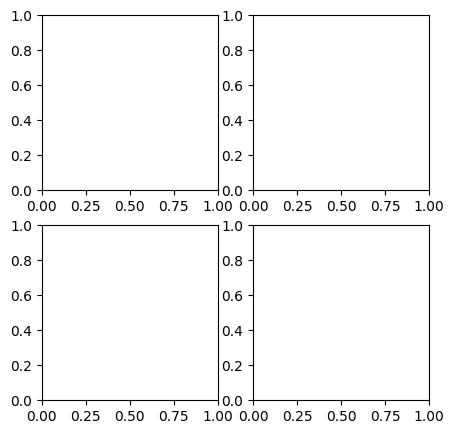

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(5,5))
x = range(10)
y = range(10)

c=0
for row in ax:
    for col in row:
        embedding_method = embedding_list[c]
        col.scatter(x, y)

In [93]:
embedding_list = ['fastrp_embeddings','graphsage_embeddings', 'hashgnn_embeddings', 'node2vec_embeddings']
embedding_title = ['FastRP','GraphSAGE','HashGNN','Node2Vec']
plot_by='SAB_CAT'

In [92]:
embedding_list

['fastrp_embeddings',
 'graphsage_embeddings',
 'hashgnn_embeddings',
 'node2vec_embeddings']

fastrp_embeddings
graphsage_embeddings
hashgnn_embeddings
node2vec_embeddings


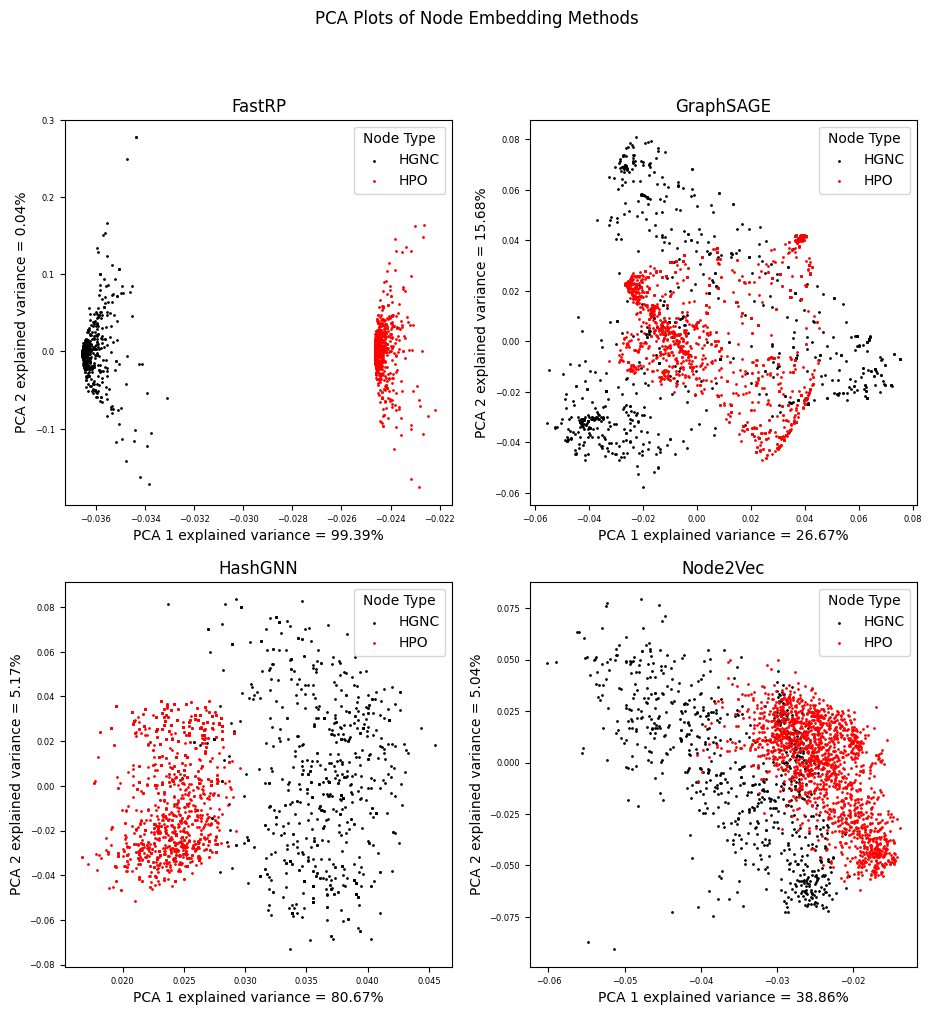

In [97]:
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(11,11))

c=0
for row in ax:
    for col in row:
        embedding_method = embedding_list[c]
        print(embedding_method)
        #col.scatter(x, y)
        # query node properties and return (embedding_method,SAB_CAT)
        query_get_props=f"""CALL gds.graph.nodeProperties.stream('{G.name()}',['{embedding_method}','SAB_CAT'],{G.node_labels()}, {{ listNodeLabels: true }})
        YIELD nodeId,nodeProperty,propertyValue,nodeLabels RETURN * """
        res = gds.run_cypher(query_get_props); res.index = res.nodeId  ; res['nodeLabels'] = [i[0] for i in res['nodeLabels']]
        rnz = pd.pivot(res,columns='nodeProperty',values='propertyValue');rnz['nodeId'] = rnz.index
        rnz = pd.merge(rnz,res[res.index.duplicated(keep='first')][['nodeLabels']], left_index=True, right_index=True).drop('nodeId',axis=1)
        rnz.reset_index(drop=True,inplace=True)        
        colors = ['k','r','b','c']
        
        if plot_by=='SAB_CAT':
            #plt.figure(figsize=(5,5))
            ax_list = []
            sab_cat_list = []
            DISTINCT_SAB_CAT=rnz.SAB_CAT.drop_duplicates()
            for N,SAB_CAT in enumerate(DISTINCT_SAB_CAT):
                    #print(N,SAB_CAT)   
                    df_temp = rnz[rnz['SAB_CAT']==SAB_CAT]
                    df_emb = pd.DataFrame(df_temp[embedding_method].tolist(), index= df_temp.index).T
                    pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)
                    plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(df_temp)
                    axb = col.scatter(plot_map['pca1'], plot_map['pca2'], s=1, marker='o', color=colors[N])
                    ax_list.append(axb)
                    sab_cat_list.append(SAB_CAT)
                    sab_cat_list = ['HGNC','HPO']

        col.set_title(embedding_title[c])
        col.xaxis.set_tick_params(labelsize=6)
        col.yaxis.set_tick_params(labelsize=6)
        col.legend(ax_list,sab_cat_list,title='Node Type')  
        col.set_xlabel(f'PCA 1 explained variance = {np.round(pca.explained_variance_ratio_[0]*100,2)}%')
        col.set_ylabel(f'PCA 2 explained variance = {np.round(pca.explained_variance_ratio_[1]*100,2)}%')
        
        c=c+1
fig.suptitle('PCA Plots of Node Embedding Methods')
plt.show()

fig.savefig('pca_node_embeddings.pdf',dpi=100)

In [86]:
#community_props | {'louvainCommunityId','lpaCommunityId'} | {'one_hot_sab'}

### See how including different properties, esp. community id's, change the embeddings and prediction accuracy

In [16]:
# properties to use as inputs for the embedding method
embedding_inputs = list(scaled_props | {'degreeCentrality'})# | {'one_hot_sab'})
print(embedding_inputs)

# names of the embedding properteis (hashgnn, graphsage, etc.)
embedding_props = set()
embedding_dimension = 64

['pageRankScore_scale', 'degreeCentrality']


## FastRP embedding
https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/fastrp/
Try just streaming fastrp directly b/c and it takes a long time to stream the fastrp property back After they written to the project graph (wont get ids/props/labels though?) .If propertyRatio<1.0, most of the nodes in the graph that a prediction is being run on, must be the same nodes (in the database sense) as in the original graph "g" that was used during training. The reason for this is that FastRP is a random algorithm, and in this case is seeded based on the nodes' ids in the Neo4j database from whence the nodes came.
If propertyRatio=1.0 however, the random initial node embeddings are derived from node property vectors only, so there is no random seeding based on node ids.  Additionally, in order for the initial random vectors (independent of propertyRatio used) to be consistent between runs (training and prediction calls), a value for the randomSeed configuration parameter must be provided when adding the FastRP node property step to the training pipeline.

In [101]:
gds.graph.nodeProperties.drop(G,'fastrp_embeddings')

ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.nodeProperties.drop`: Caused by: java.lang.IllegalArgumentException: Could not find property key(s) ['hashgnn_embedding']. Defined keys: ['SAB_CAT', 'articleRankScore', 'articleRankScore_scale', 'betweennessCentrality', 'betweennessCentrality_scale', 'degreeCentrality', 'degreeCentrality_scale', 'graphsage_embeddings', 'node2vec_embeddings', 'one_hot_sab', 'pageRankScore', 'pageRankScore_scale'].}

In [17]:
%%time

if 'fastrp_embeddings' not in G.node_properties()[0]: 
    
    fastrp_result = gds.fastRP.mutate(
        G, featureProperties=embedding_inputs, 
        embeddingDimension=embedding_dimension, propertyRatio=0.4,
        iterationWeights = [0.8, 1, 1, 1], mutateProperty="fastrp_embeddings")  #relationshipWeightProperty="cost",)

    embedding_props.add('fastrp_embeddings')
    
#plotting.get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='NODE_LABEL')
#plotting.get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='SAB_CAT')
#get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='SAB_CAT')
#get_embeddings_and_plot(graph_obj=G,embedding_method='fastrp_embeddings',plot_by='NODE_LABEL')

CPU times: user 5.61 ms, sys: 0 ns, total: 5.61 ms
Wall time: 141 ms


In [45]:
# see if streaming results for millions of nodes is faster than mutate and query
#q"""CALL gds.fastRP.stream('persons', {embeddingDimension: 512, randomSeed: 42})
#YIELD nodeId, embedding RETURN"""
#gds.fastRP.stream

## HashGNN embedding
https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/hashgnn/#algorithms-embeddings-hashgnn-syntax

In [85]:
embedding_props = embedding_props - {'hashgnn_embeddings'}
gds.graph.nodeProperties.drop(G,'hashgnn_embeddings')


graphName            largest_connected_components
nodeProperties               [hashgnn_embeddings]
propertiesRemoved                            2172
Name: 0, dtype: object

In [57]:
embedding_inputs

['degreeCentrality', 'pageRankScore_scale']

In [18]:
%%time
if 'hashgnn_embeddings' not in G.node_properties()[0]:

    hashgnn_result = gds.hashgnn.mutate(G, heterogeneous = True,
                       iterations = 30,
                       embeddingDensity = embedding_dimension,
                       neighborInfluence=0.7,
                       mutateProperty='hashgnn_embeddings',
                       binarizeFeatures = {'dimension' : 64, 'threshold' : 0.2},
                       featureProperties = embedding_inputs,
                       outputDimension = embedding_dimension, # dim of hashgnn_embedding
                       #contextNodeLabels = G.node_labels(), 
                       randomSeed = 42)

    embedding_props.add('hashgnn_embeddings')

    print(hashgnn_result)
    
#get_embeddings_and_plot(graph_obj=G,embedding_method='hashgnn_embeddings',plot_by='NODE_LABEL')   
#get_embeddings_and_plot(graph_obj=G,embedding_method='hashgnn_embeddings',plot_by='SAB_CAT')

nodePropertiesWritten                                                 2428
mutateMillis                                                             0
nodeCount                                                             2428
preProcessingMillis                                                      0
computeMillis                                                         3238
configuration            {'randomSeed': 42, 'mutateProperty': 'hashgnn_...
Name: 0, dtype: object
CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 3.28 s


hashgnn_embeddings:  # of unique embeddings: 1 out of 2169 total nodes
using (64,) dimensions.


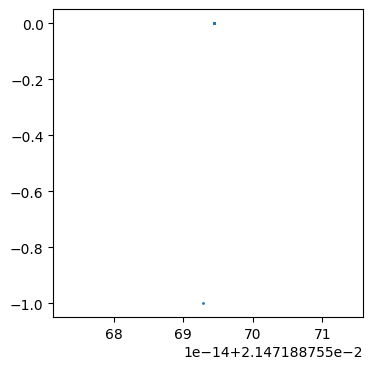

In [98]:
query_get_props=f"""CALL gds.graph.nodeProperties.stream('{G.name()}','hashgnn_embeddings',['Concept','Unknown'])
YIELD nodeId,nodeProperty,propertyValue,nodeLabels RETURN * """
res = gds.run_cypher(query_get_props)

#embedding_str = res.apply( lambda x: ( ''.join(map(str,x['propertyValue']))  ),axis=1)
unique_embeddings = len(np.unique(res["propertyValue"]))  
print(f'hashgnn_embeddings:  # of unique embeddings: {unique_embeddings} out of {len(res)} total nodes\nusing {np.shape(res["propertyValue"][0])} dimensions.')

df_emb = pd.DataFrame(res['propertyValue'].tolist(), index= res.index).T
pca = PCA(n_components=2,svd_solver='full'); pca.fit(df_emb)

plot_map = pd.DataFrame(pca.components_,index=['pca1','pca2']).T; assert len(plot_map) == len(res)
plt.figure(figsize=(4,4))
plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1)#,c=plot_map['colors'])

In [104]:
np.unique(pca.components_)
res[['propertyValue']].drop_duplicates()
#pd.DataFrame(res['propertyValue'].tolist(), index= res.index)
pd.DataFrame(pca.components_,index=['pca1','pca2']).T.drop_duplicates()

,propertyValue
0,"[0.21650634706020355, 0.0, -0.4330126941204071..."


## Node2Vec
https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/node2vec/

In [104]:
gds.graph.nodeProperties.drop(G,'node2vec_embeddings')

graphName            largest_connected_components
nodeProperties              [node2vec_embeddings]
propertiesRemoved                            2160
Name: 0, dtype: object

In [19]:
%%time

if 'node2vec_embeddings' not in G.node_properties()[0]:
    
    node2vec_result = gds.node2vec.mutate(G,
                        embeddingDimension = embedding_dimension,
                        walkLength=12,
                        walksPerNode=12,
                        iterations=16,inOutFactor=1, mutateProperty='node2vec_embeddings')

    embedding_props.add('node2vec_embeddings')
    print(node2vec_result)
    #get_embeddings_and_plot(graph_obj=G,embedding_method='node2vec_embeddings')
#get_embeddings_and_plot(graph_obj=G,embedding_method='node2vec_embeddings',plot_by='NODE_LABEL')  
#get_embeddings_and_plot(graph_obj=G,embedding_method='node2vec_embeddings',plot_by='SAB_CAT')

nodeCount                                                             2428
nodePropertiesWritten                                                 2428
lossPerIteration         [1459442.3591999875, 602826.4746746919, 526676...
mutateMillis                                                             0
postProcessingMillis                                                     0
preProcessingMillis                                                      0
computeMillis                                                        14492
configuration            {'walkLength': 12, 'walkBufferSize': 1000, 'mu...
Name: 0, dtype: object
CPU times: user 25 ms, sys: 851 µs, total: 25.8 ms
Wall time: 14.5 s


## GraphSAGE
https://neo4j.com/docs/graph-data-science/current/machine-learning/node-embeddings/graph-sage/#graph-sage-trained-model-example-mutate

In [124]:
#MODEL_NAME='newGmodel'
gds.model.drop(gds.model.get(MODEL_NAME) )

ValueError: No loaded model named 'gene-predictor-model' exists

In [43]:
scaled_props

set()

In [20]:
# Train first then mutate
# More layers result in more distant neighbors being considered for a node’s embedding. 

GRAPHSAGE_EMB_NAME = 'graphsage_embeddings'

if GRAPHSAGE_EMB_NAME not in G.node_properties()[0]:
    
    MODEL_NAME='newGmodel'

    gs_model, graphSageTrain_results = gds.beta.graphSage.train(G,
                                     modelName = MODEL_NAME,
                                     featureProperties = embedding_inputs,
                                     projectedFeatureDimension = embedding_dimension,
                                     aggregator= 'pool',   # 'mean' is faster
                                     activationFunction= 'ReLu', #'sigmoid',
                                     sampleSizes = [25, 10], # defines num_layers and size of each layer 
                                     epochs = 15,
                                     maxIterations = 80,
                                     randomseed=19)
    # write to graph
    gs_result = gds.beta.graphSage.mutate(G, mutateProperty = GRAPHSAGE_EMB_NAME, modelName =  MODEL_NAME)
    embedding_props.add(GRAPHSAGE_EMB_NAME)
    #print(gs_result)

#get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='NODE_LABEL')
#get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='SAB_CAT')    

graphsage_embeddings:  # of unique embeddings: 1592 out of 2428 total nodes
using (64,) dimensions.
graphsage_embeddings:  # of unique embeddings: 1592 out of 2428 total nodes
using (64,) dimensions.


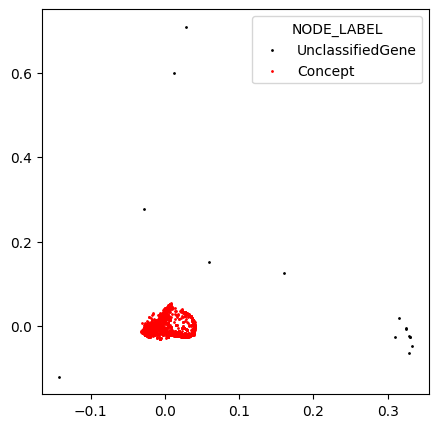

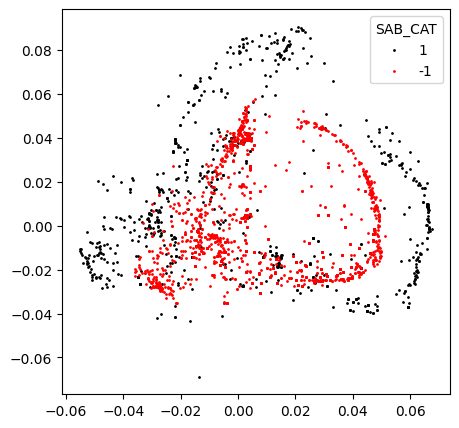

In [43]:
#gds.graph.nodeProperties.drop(G,'graphsage_embeddings') 
get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='NODE_LABEL')
get_embeddings_and_plot(graph_obj=G,embedding_method=GRAPHSAGE_EMB_NAME,plot_by='SAB_CAT')

### Create plot of Embedding PCA space

In [ ]:
x = range(10)
y = range(10)

fig, ax = plt.subplots(nrows=2, ncols=2)

for row in ax:
    for col in row:
        col.plot(x, y)

plt.show()

# 2c) Get results of embeddings and reformat for dimensionality reduction and plotting

In [176]:
#all_props = ['fastrp','hashgnn','node2vec','graphsage','louvainCommunityId','lpaCommunityId']#,'SAB','STY']
all_props = list(scaled_props)  + list(embedding_props) + ['one_hot_sab','SAB_CAT'] 
all_props

['pageRankScore_scale',
 'graphsage_embeddings',
 'node2vec_embeddings',
 'fastrp_embeddings',
 'hashgnn_embeddings',
 'one_hot_sab',
 'SAB_CAT']

In [94]:
%%time

query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",{all_props},{G.node_labels()},{{ listNodeLabels: true }})
YIELD
    nodeId,
    nodeLabels,
    nodeProperty, propertyValue
    RETURN nodeId, nodeLabels, nodeProperty, propertyValue"""

res = gds.run_cypher(query_get_props)
print(f'{sys.getsizeof(res) / 1000000000.0} GB')

# Pivot df so that algo scores are columns 
res.index = res.nodeId  
rnzp = pd.pivot(res,columns='nodeProperty',values='propertyValue')

# Merge in string props (codeID, Term name)

rnzp['nodeId'] = rnzp.index
rnzp.reset_index(drop=True,inplace=True)

df_props = pd.merge(rnzp,df_map.drop('SAB_CAT',axis=1).reset_index(drop=True),on='nodeId')
#df_props.rename(columns={'source.SAB_CAT':'SAB_CAT'})
assert len(rnzp) == len(df_props)

df_props.head(2)

0.009580856 GB
CPU times: user 840 ms, sys: 44 ms, total: 884 ms
Wall time: 926 ms


,SAB_CAT,betweennessCentrality_scale,degreeCentrality_scale,graphsage_embeddings,hashgnn_embeddings,node2vec_embeddings,one_hot_sab,pageRankScore_scale,nodeId,nodeLabels,STY,SAB,codeID,term
0,1,[-0.006681293036183014],[-0.0077553557865384795],"[-0.00028391886129556745, -0.00215869931500490...","[0.21650634706020355, 0.0, 0.0, 0.216506347060...","[-0.11396626383066177, 0.1118168905377388, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.009726655749910617],7210,[Concept],Gene or Genome,HGNC,HGNC:30935,YY1 ASSOCIATED PROTEIN 1
1,1,[-0.006269338226932484],[-0.0035180676509452592],"[-0.0002139117175016878, -0.001940693509012949...","[0.0, 0.4330126941204071, 0.21650634706020355,...","[0.03360384702682495, 0.13797567784786224, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.004932315116639962],7213,[Concept],Gene or Genome,HGNC,HGNC:10549,ataxin 10


In [40]:
Counter([i[0] for i in res['nodeLabels']])

Counter({'Concept': 14378, 'Unknown': 819})

In [95]:
def make_unique_color_col(df_props,column):

    df_uniq_col = pd.DataFrame(df_props[column].unique(),columns=[column])
    num_colors = len(df_uniq_col)
    df_uniq_col[column+'_colors'] = distinctipy.get_colors(num_colors)

    df_props_merge = pd.merge(df_uniq_col,df_props,on=column)
    assert len(df_props) == len(df_props_merge)
    return df_props_merge


# Create color maps
for col in ['louvainCommunityId','lpaCommunityId','SAB','SAB_CAT','STY']:
   
    if col in df_props.columns:
        print(f' making unique color map for all values in {col} Column.')
        df_props = make_unique_color_col(df_props,col)

 making unique color map for all values in SAB Column.
 making unique color map for all values in SAB_CAT Column.
 making unique color map for all values in STY Column.


In [137]:
#df_props['hashgnn_embedding_str'] = df_props.apply( lambda x: ( ''.join(map(str,x['hashgnn_embedding']))  )
#                                                       ,axis=1)
#len(np.unique(df_props['hashgnn_embedding_str']))

# 3) Dimensionality Reduction of Embedding and Initial Visualization

## PCA 

In [44]:
def pca_plotter(df_props,EMBEDDING_METHOD,COL_TO_COLOR_BY,NUM_PCA_COMP):
    '''Helper function for plotting the embedding methods, can also color by a column'''
    df_emb = df_props[[EMBEDDING_METHOD]]
    df_plot = df_props[[COL_TO_COLOR_BY,COL_TO_COLOR_BY+'_colors']]
    df_plot.columns = [COL_TO_COLOR_BY,'colors']

    sums = df_emb.apply( lambda x: (sum(x[EMBEDDING_METHOD]) ),axis=1)

    res_nz = df_emb[sums!=0]; res_nz = res_nz.reindex()
    df_plot = df_plot[sums!=0]; df_plot = df_plot.reindex()
    assert len(df_emb.shape) == len(res_nz.shape)

    df_emb = pd.DataFrame(res_nz[EMBEDDING_METHOD].tolist(), index= res_nz.index)
    del sums, res_nz

    if NUM_PCA_COMP == 3: PCA_COLS = ['pca1','pca2','pca3']
    elif NUM_PCA_COMP == 2: PCA_COLS = ['pca1','pca2']

    pca = PCA(n_components=NUM_PCA_COMP)
    pca.fit(df_emb.T)

    plot_map = pd.concat([df_plot['colors'],pd.DataFrame(pca.components_,index=PCA_COLS).T],axis=1)
    assert len(plot_map) == len(pca.components_.T)
    
    if NUM_PCA_COMP==2:
        plt.figure(figsize=(8,8))
        
        plt.scatter(plot_map['pca1'], plot_map['pca2'], s=1,c=plot_map['colors'])
        plt.title(f'{EMBEDDING_METHOD}, colored by {COL_TO_COLOR_BY}',size=20)
        
    elif NUM_PCA_COMP==3:
        ### 3-D plots
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(projection='3d')
        ax.scatter(plot_map['pca1'], plot_map['pca2'], plot_map['pca3'],s=1,c=plot_map['colors'])
        plt.title(f'{EMBEDDING_METHOD}:{COL_TO_COLOR_BY}',size=20)
        
    #plt.legend((),
    #       ('Low Outlier', 'LoLo', 'Lo', 'Average', 'Hi', 'HiHi', 'High Outlier'),
    #       scatterpoints=1,
    #       loc='lower left',
    #       ncol=3,
    #       fontsize=8)
    #return plot_map
    
#plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0))

In [100]:
df_props

,STY,STY_colors,SAB_CAT,SAB_CAT_colors,SAB,SAB_colors,betweennessCentrality_scale,degreeCentrality_scale,graphsage_embeddings,hashgnn_embeddings,node2vec_embeddings,one_hot_sab,pageRankScore_scale,nodeId,nodeLabels,codeID,term
0,Gene or Genome,"(0.0, 1.0, 0.0)",1,"(0.00018994452158482833, 0.9990515053279374, 0...",HGNC,"(0.0, 1.0, 0.0)",[-0.006681293036183014],[-0.0077553557865384795],"[-0.00028391886129556745, -0.00215869931500490...","[0.21650634706020355, 0.0, 0.0, 0.216506347060...","[-0.11396626383066177, 0.1118168905377388, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.009726655749910617],7210,[Concept],HGNC:30935,YY1 ASSOCIATED PROTEIN 1
1,Gene or Genome,"(0.0, 1.0, 0.0)",1,"(0.00018994452158482833, 0.9990515053279374, 0...",HGNC,"(0.0, 1.0, 0.0)",[-0.006269338226932484],[-0.0035180676509452592],"[-0.0002139117175016878, -0.001940693509012949...","[0.0, 0.4330126941204071, 0.21650634706020355,...","[0.03360384702682495, 0.13797567784786224, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.004932315116639962],7213,[Concept],HGNC:10549,ataxin 10
2,Gene or Genome,"(0.0, 1.0, 0.0)",1,"(0.00018994452158482833, 0.9990515053279374, 0...",HGNC,"(0.0, 1.0, 0.0)",[-0.002080933866636854],[0.006368937998772255],"[-0.0066883646180063115, -0.007110000154027367...","[0.4330126941204071, 0.0, -0.21650634706020355...","[-0.258388489484787, 0.45164692401885986, -0.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0.0037270792918053693],38295,[Concept],HGNC:26013,DYNEIN AXONEMAL ASSEMBLY FACTOR 5
3,Gene or Genome,"(0.0, 1.0, 0.0)",1,"(0.00018994452158482833, 0.9990515053279374, 0...",HGNC,"(0.0, 1.0, 0.0)",[0.03750583770882339],[0.09252713008916774],"[0.6328622229704643, -0.007517458204569957, -0...","[0.0, 0.0, 0.4330126941204071, 0.4330126941204...","[-0.2223694771528244, 0.3688991367816925, 0.18...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0.08231580726942021],38306,[Concept],HGNC:12744,MLXIPL Gene
4,Gene or Genome,"(0.0, 1.0, 0.0)",1,"(0.00018994452158482833, 0.9990515053279374, 0...",HGNC,"(0.0, 1.0, 0.0)",[-0.006170971750211106],[-0.009167785165069553],"[-0.0019826805898972245, -0.000361518335566517...","[0.21650634706020355, 0.21650634706020355, 0.2...","[-0.24320414662361145, 0.13469743728637695, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.009736837369588034],38440,[Concept],HGNC:24682,FLVCR heme transporter 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2167,Cell or Molecular Dysfunction,"(0.0, 1.0, 0.5)",2,"(1.0, 0.0, 1.0)",HPO,"(1.0, 0.0, 1.0)",[-0.007096787425535581],[-0.006342926408007406],"[-0.024218238428808766, -0.0059631778539103765...","[0.21650634706020355, 0.0, 0.4330126941204071,...","[-0.7206441164016724, 0.24118945002555847, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.009411020421986206],3077220,[Concept],HPO:0003220,Abnormality of chromosome stability
2168,Cell or Molecular Dysfunction,"(0.0, 1.0, 0.5)",2,"(1.0, 0.0, 1.0)",HPO,"(1.0, 0.0, 1.0)",[-0.007162425474321499],[-0.017642361436255995],"[-0.02713332448650245, -0.008345172999071317, ...","[0.4330126941204071, 0.0, 0.0, 0.0, 0.21650634...","[-0.25823524594306946, 0.32248029112815857, -0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.015940274645678484],3617055,[Concept],HPO:0031381,Decreased lymphocyte proliferation in response...
2169,Cell or Molecular Dysfunction,"(0.0, 1.0, 0.5)",2,"(1.0, 0.0, 1.0)",HPO,"(1.0, 0.0, 1.0)",[-0.007217066627395702],[-0.02329207895038029],"[-0.0009087286449186658, 0.051596978381335215,...","[0.4330126941204071, 0.21650634706020355, 0.0,...","[-0.17343898117542267, 0.3569228947162628, -0....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[-0.02179608160518478],7494897,[Concept],HPO:0012574,Mesangial hypercellularity
2170,Temporal Concept,"(0.5071909260805539, 0.40041016517866457, 0.00...",2,"(1.0, 0.0, 1.0)",HPO,"(1.0, 0.0, 1.0)",[-0.007159457553531782],[-0.017642361436255995],"[-0.026562556425

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

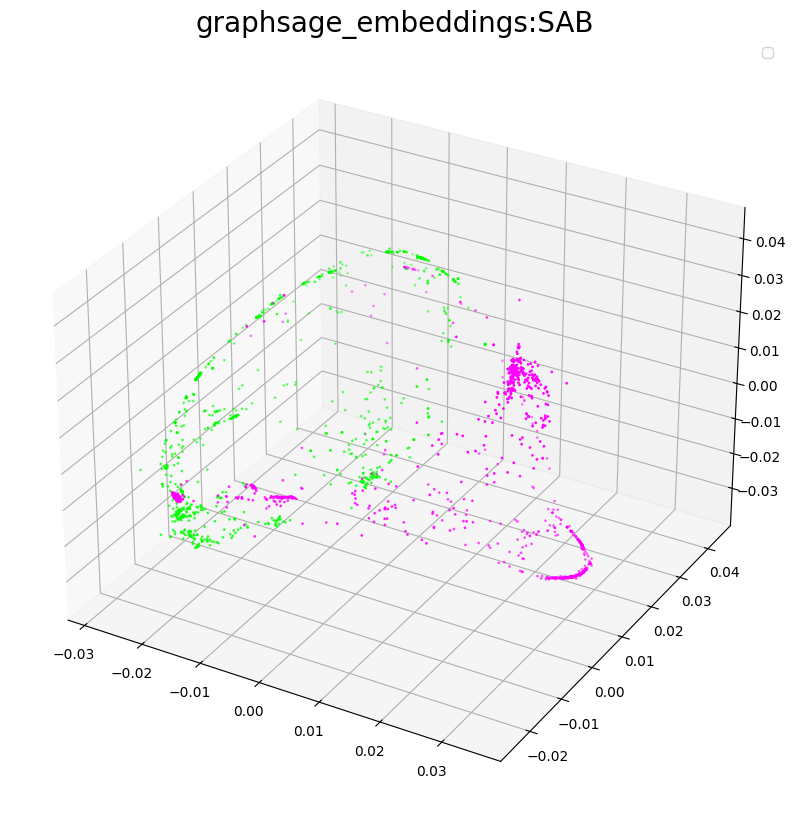

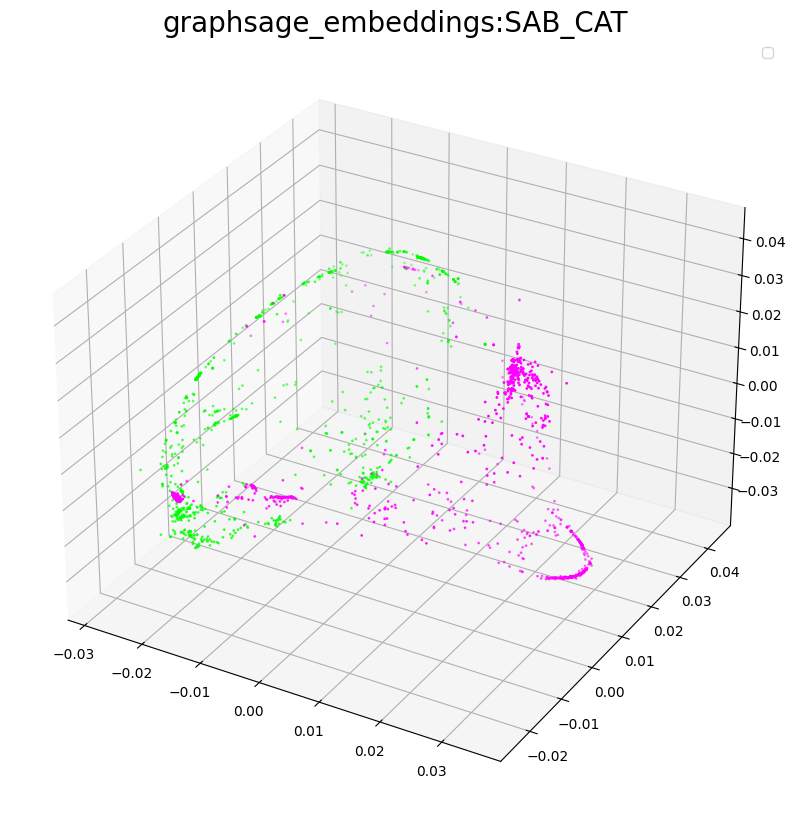

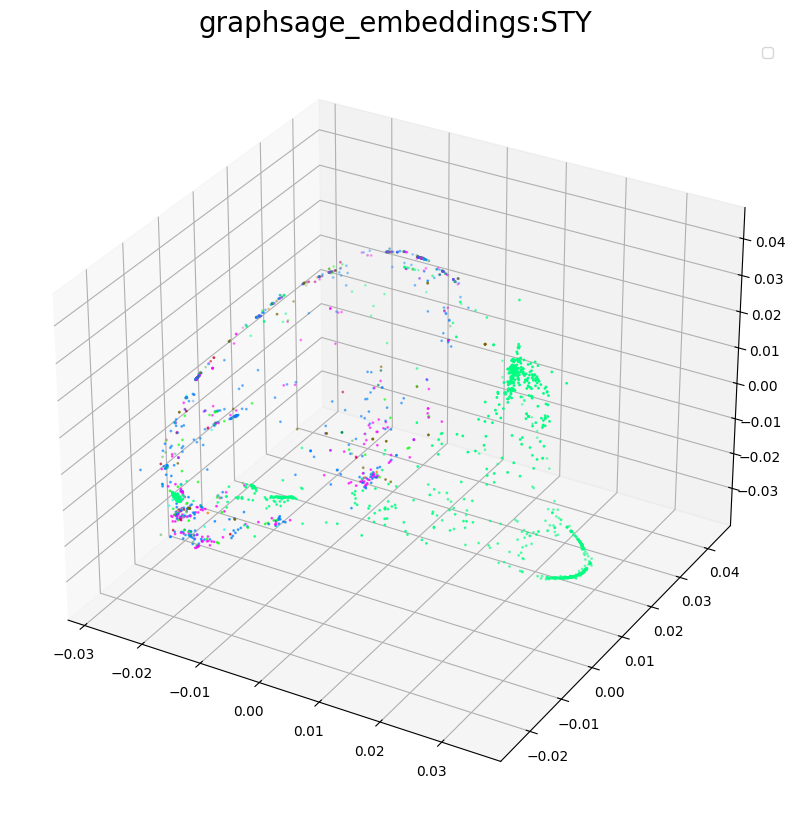

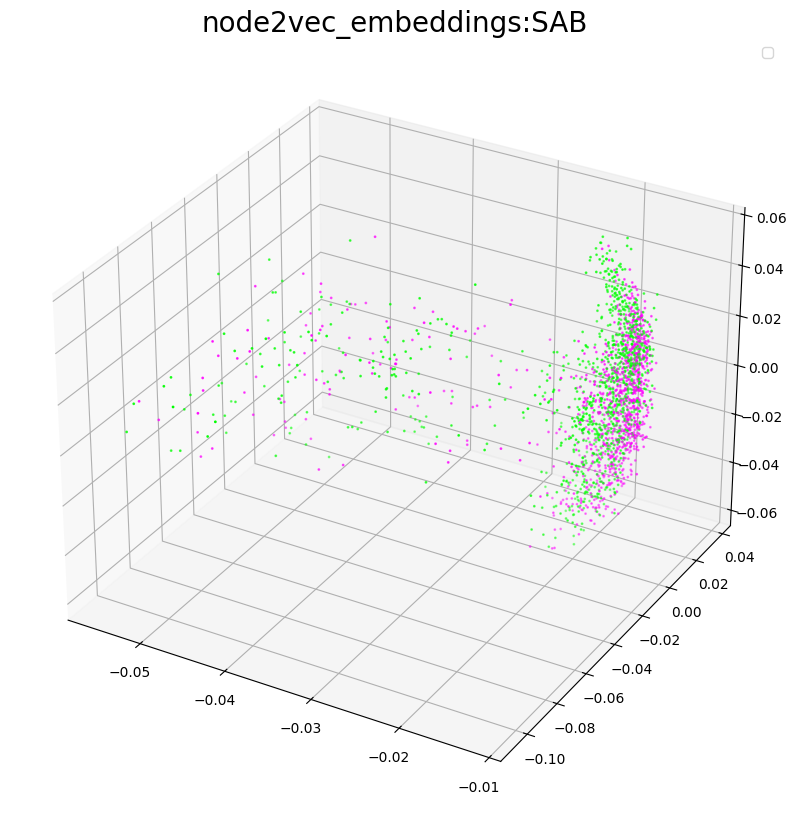

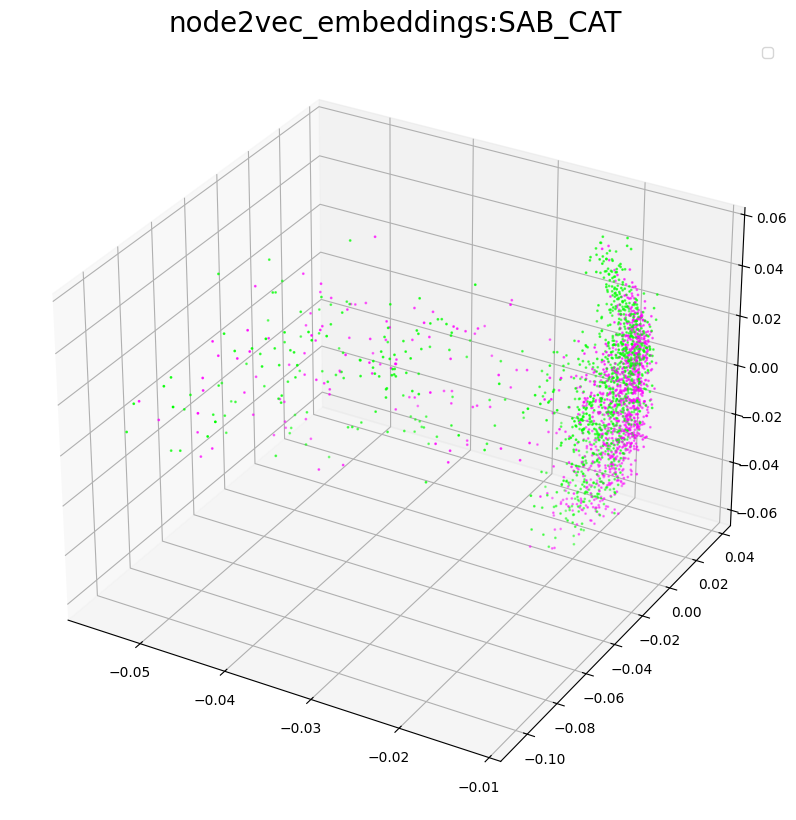

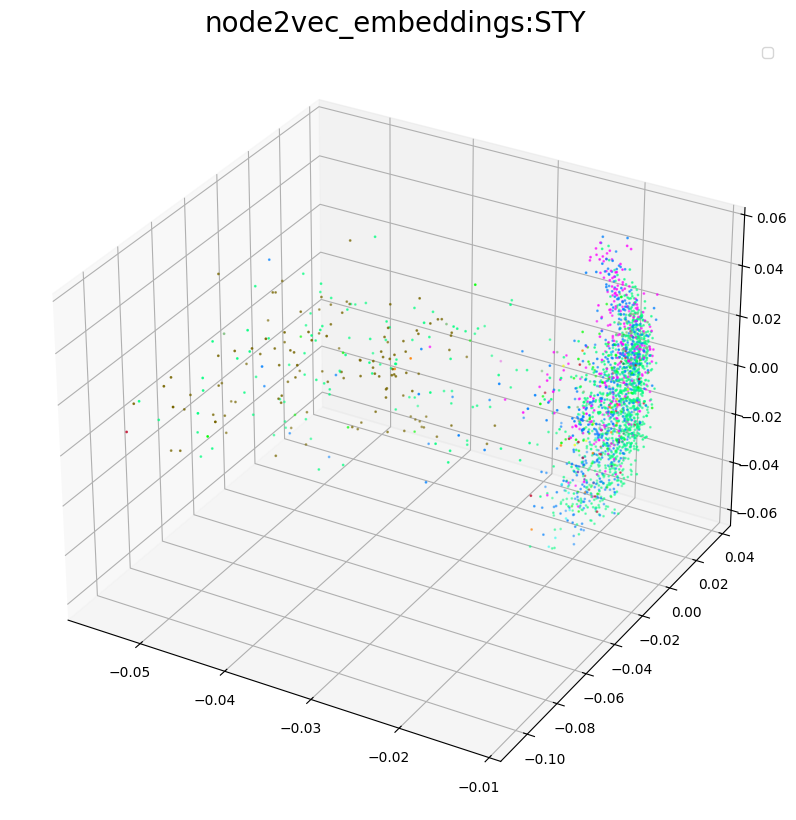

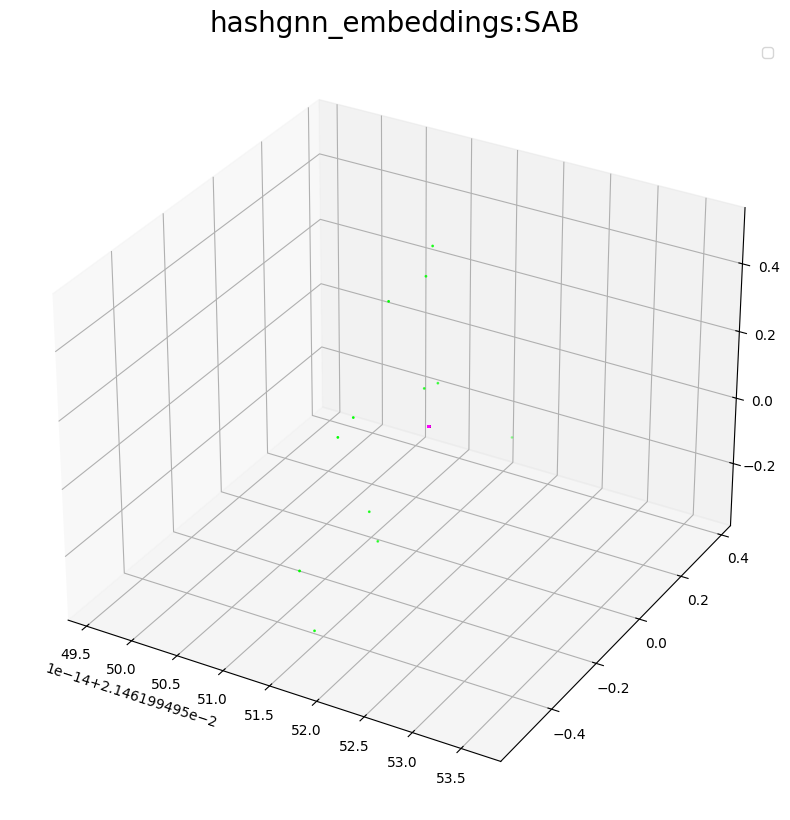

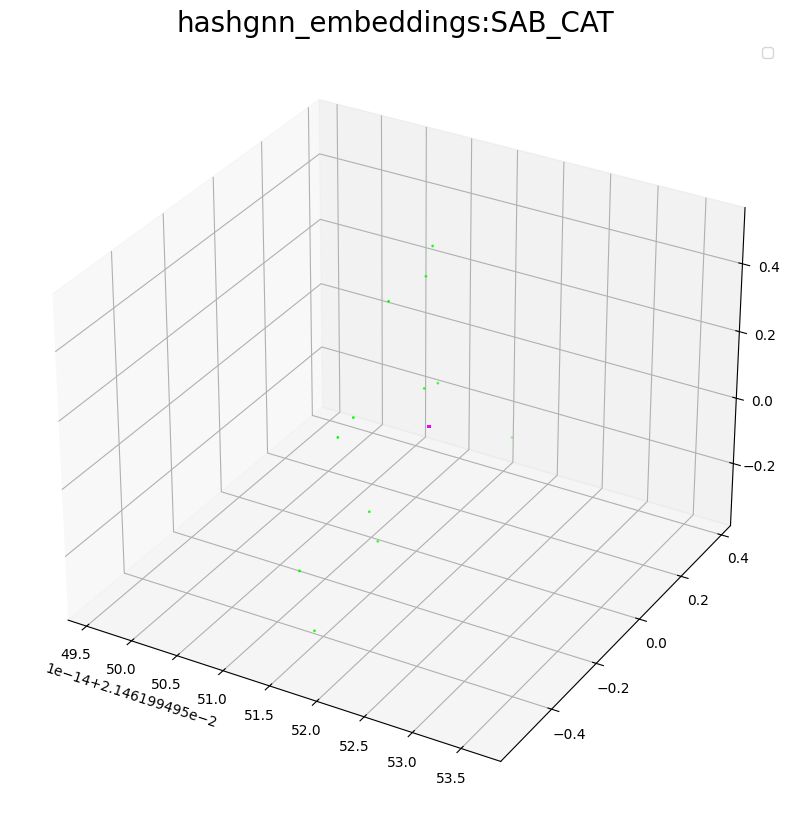

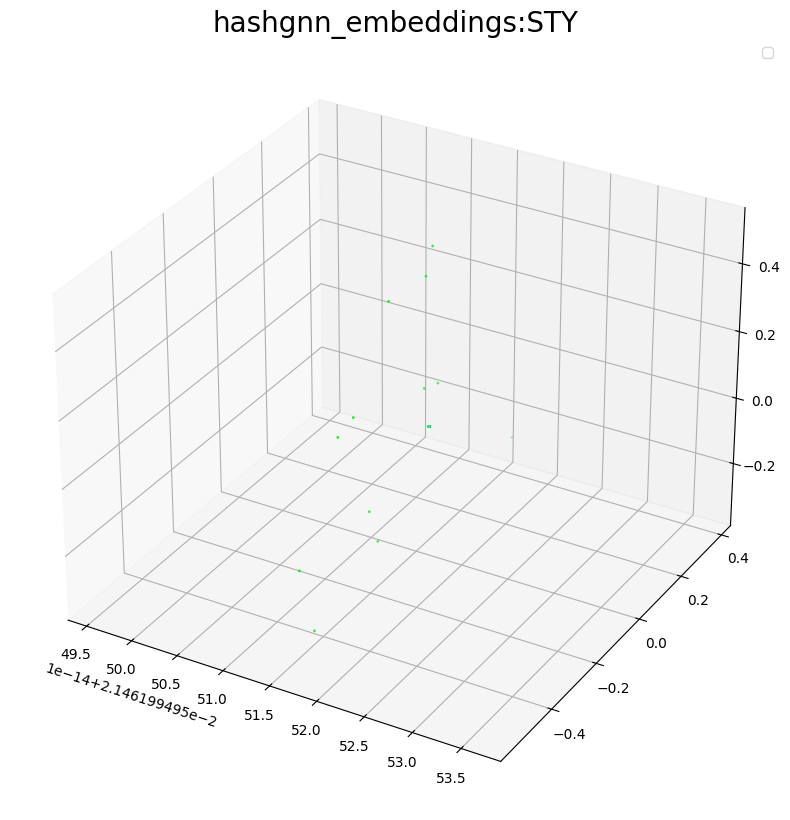

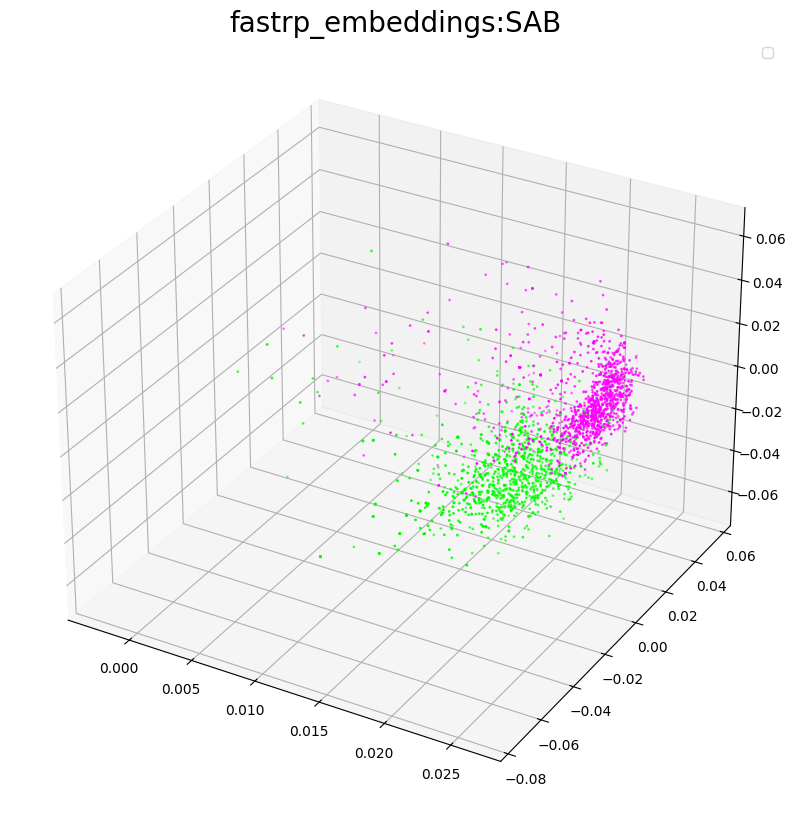

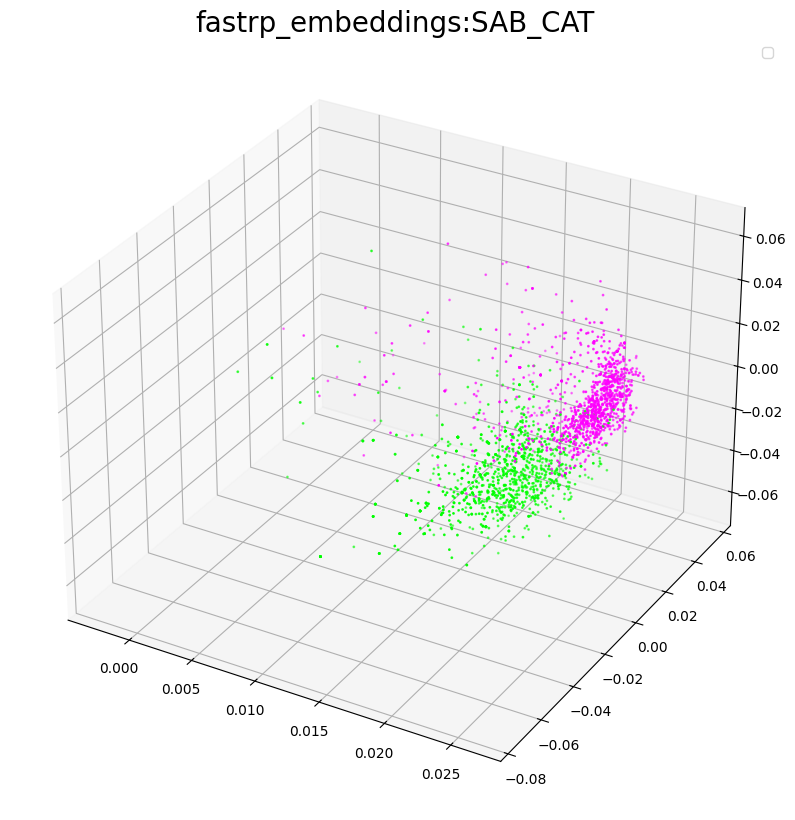

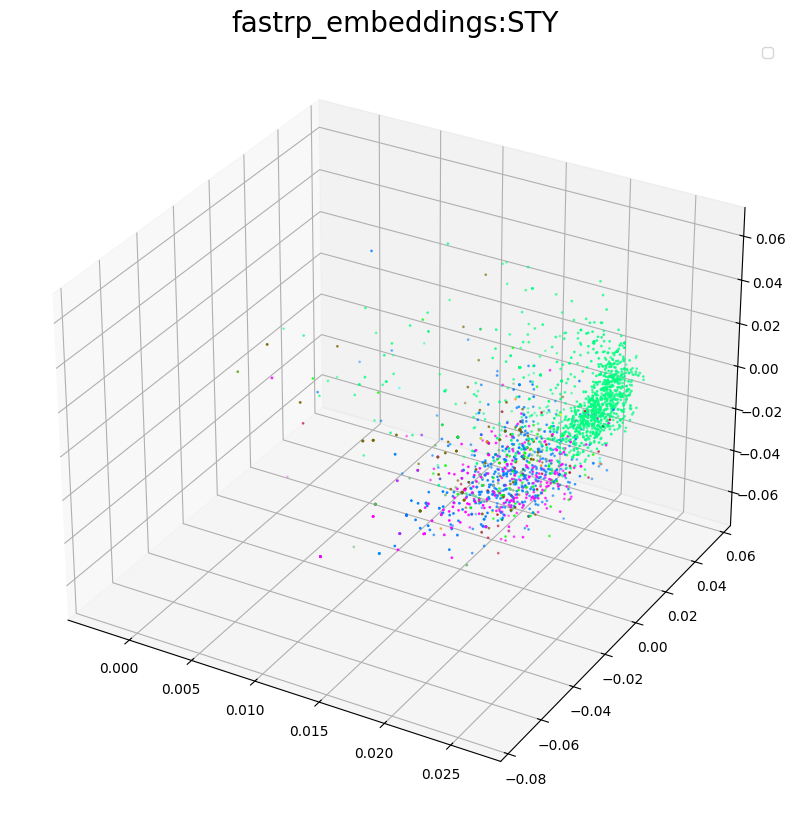

In [44]:
for embed in embedding_props:
    for color_by in ['SAB','SAB_CAT','STY']: #,'louvainCommunityId','STY','lpaCommunityId']:
        pca_plotter(df_props = df_props,
                            EMBEDDING_METHOD = embed,
                            COL_TO_COLOR_BY = color_by,
                            NUM_PCA_COMP = 3)

## T-SNE

In [148]:
EMBEDDING_METHOD='node2vec_embeddings'
COL_TO_COLOR_BY='SAB'

df_emb = df_props[[EMBEDDING_METHOD]]
df_plot = df_props[[COL_TO_COLOR_BY,COL_TO_COLOR_BY+'_colors']]
df_plot.columns = [COL_TO_COLOR_BY,'colors']

sums = df_emb.apply( lambda x: (sum(x[EMBEDDING_METHOD]) ),axis=1)

res_nz = df_emb[sums!=0]; res_nz = res_nz.reindex()
df_plot = df_plot[sums!=0]; df_plot = df_plot.reindex()
assert len(df_emb.shape) == len(res_nz.shape)

df_emb = pd.DataFrame(res_nz[EMBEDDING_METHOD].tolist(), index= res_nz.index)
del sums, res_nz

In [149]:
# DO PCA --> ~50 dimensions first

NUM_PCA_COMP_TSNE=32

pca = PCA(n_components=NUM_PCA_COMP_TSNE)
pca.fit(df_emb.T)
print(np.shape(pca.components_.T))

(1959, 32)


In [150]:
np.shape(df_emb.T)

(64, 1959)

In [151]:
np.shape(pca.components_)

(32, 1959)

In [152]:
%%time

tsne = TSNE(n_components=2,
        init="random", random_state=0,
        perplexity=3, n_iter=300,
        n_jobs=-1 ).fit_transform(pca.components_)

CPU times: user 11.9 s, sys: 155 ms, total: 12 s
Wall time: 214 ms


In [153]:
plot_map = pd.DataFrame(tsne,columns=['tsne1','tsne2'])
plot_map

,tsne1,tsne2
0,350.625305,116.836197
1,123.196838,376.518646
2,341.214966,-183.850845
3,209.678207,-150.092148
4,-183.254425,173.440994
5,-23.327532,355.726654
6,226.084244,-11.247297
7,207.307465,126.894127
8,364.123962,-31.696663
9,60.880562,-370.251282


Text(0.5, 1.0, 'Concept embeddings colored by SAB type')

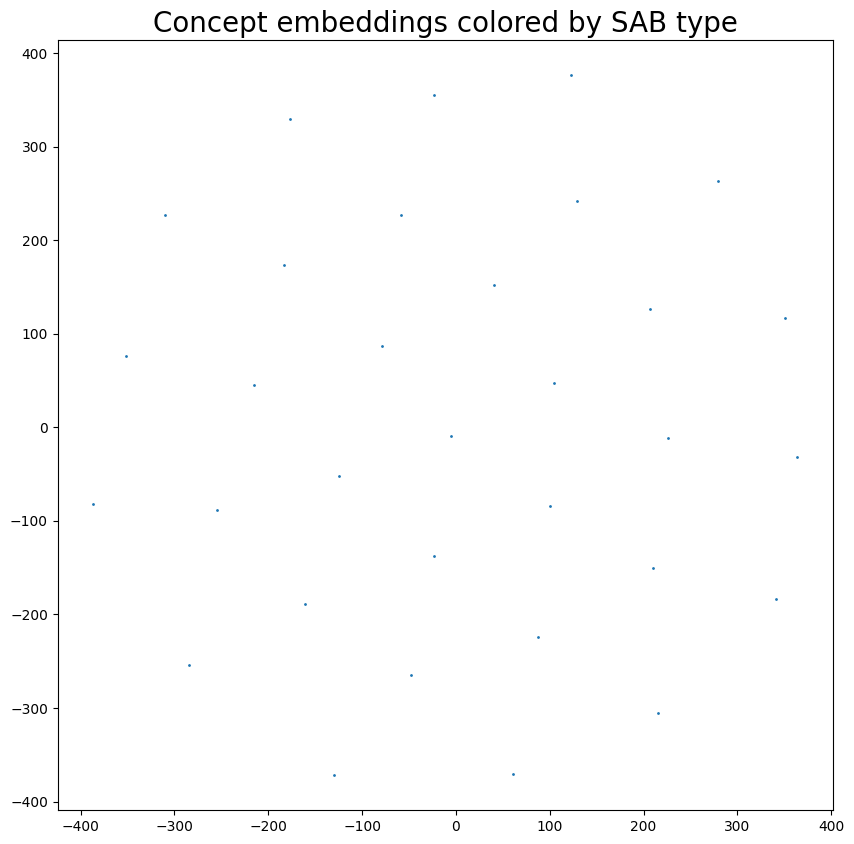

In [154]:
plt.figure(figsize=(10,10))
plt.scatter(plot_map['tsne1'], plot_map['tsne2'], s=1)#,c=plot_map['colors'])
plt.title('Concept embeddings colored by SAB type',size=20)

## Check property distributions by node types

articleRankScore: P-value: 0.2672430597869985, statistic: 0.06933093603574153
degreeCentrality: P-value: 0.34006452036746654, statistic: 0.06494497112346083
pageRankScore: P-value: 0.19024455272192906, statistic: 0.07505175983436853
betweennessCentrality: P-value: 0.110746664488188, statistic: 0.08333333333333333


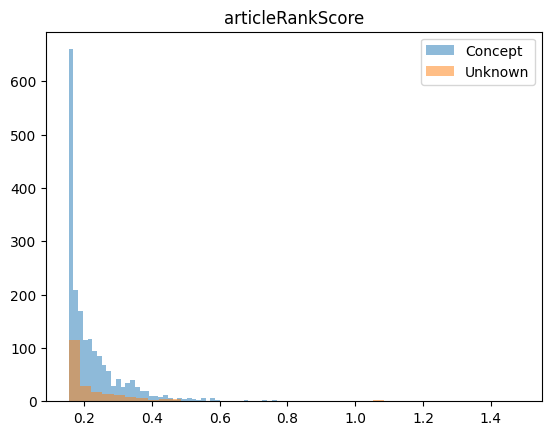

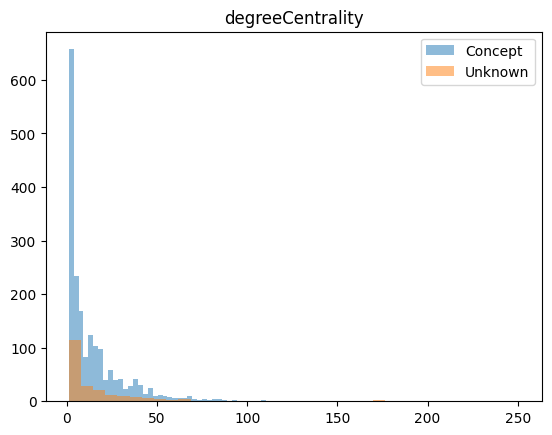

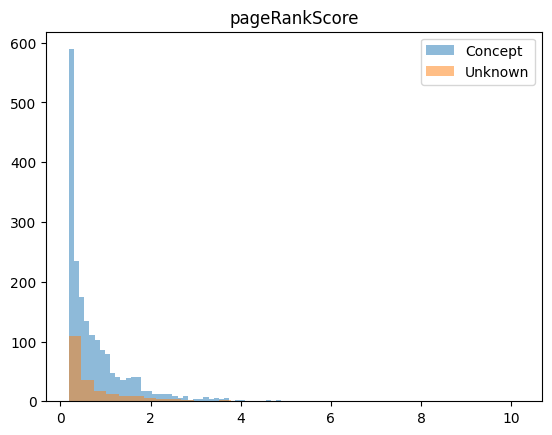

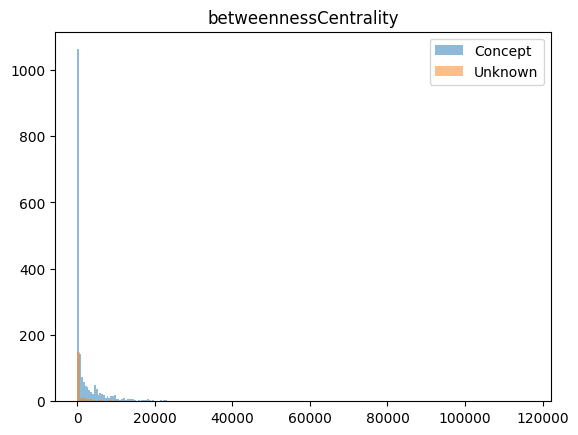

In [79]:
query_get_props=\
f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",{list(props)},'*',{{ listNodeLabels: true }})
YIELD nodeId, nodeProperty, propertyValue, nodeLabels
    RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""

res = gds.run_cypher(query_get_props)
res.head(2)

res['nodeLabels'] = [i[0] for i in res['nodeLabels']]
np.unique(res['nodeLabels'])
lbl_id_map = res[['nodeLabels','nodeId']]
lbl_id_map.index = lbl_id_map['nodeId']
lbl_id_map = lbl_id_map.drop_duplicates()

res = res.drop(['name'],axis=1)
res.index = res.nodeId # need this or pivot doesnt work 
df_pvt = pd.pivot(res,columns='nodeProperty',values='propertyValue')

df_pvt['nodeId'] = df_pvt.index
df_pvt = df_pvt.merge(lbl_id_map[['nodeLabels']], how='outer', left_index=True, right_index=True)

from scipy.stats import ks_2samp, zscore # zscore is for removing outliers, sks_2samp for comparing 2 distributions

# Using SKS test: https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets
# auto bis\ns: https://stackoverflow.com/questions/33458566/how-to-choose-bins-in-matplotlib-histogram
for ALGO in set(df_pvt.columns) - set(['nodeId','nodeLabels']):

    dist_concept = df_pvt[df_pvt['nodeLabels']=='Concept'][ALGO]
    dist_unknown = df_pvt[df_pvt['nodeLabels']=='Unknown'][ALGO]
    
    ks_stat, pvalue = ks_2samp(dist_concept,dist_unknown)
    print(f'{ALGO}: P-value: {pvalue}, statistic: {ks_stat}',end='\n')
    
    # remove outliers, if the value is greater than 3-STD, remove it
    dist_concept = dist_concept[(np.abs(zscore(dist_concept)) < 3)]
    dist_unknown = dist_unknown[(np.abs(zscore(dist_unknown)) < 3)]
    
    plt.figure()
    plt.hist(dist_concept.values, bins='auto', alpha=0.5, label='Concept')
    plt.hist(dist_unknown.values, bins='auto', alpha=0.5, label='Unknown')
    plt.title(ALGO)
    plt.legend(loc='upper right')
    

# 4) Node and Link Prediction algorithms


### 4a) Simple kNN Link Prediction
https://neo4j.com/docs/graph-data-science/current/end-to-end-examples/fastrp-knn-example/

# Node property classification pipeline 
##### adapted from this tutorial: https://neo4j.com/docs/graph-data-science-client/current/tutorials/heterogeneous-node-classification-with-hashgnn/

In [5]:
for pipe_name in gds.pipeline.list()['pipelineName']:
    print(f'Dropping pipeline: {pipe_name}')
    gds.pipeline.get(pipe_name).drop()
    
for model_name in gds.model.list()['modelName']:
    #if model_name is not GRAPH_SAGE_MODEL_NAME:
        print(f'Dropping model: {model_name}')
        gds.model.get(model_name).drop()


In [6]:
MODEL_NAME="gene-predictor-model"
PIPELINE_NAME= "gene-predictor-pipe"

In [105]:
%%time

GRAPH_STR='small_graph'

for CURRENT_EMBEDDING_METHOD in embedding_props:
    print(f'Starting {CURRENT_EMBEDDING_METHOD} pipeline using {GRAPH_STR}.\n\n')
    
    try:
        pipe = gds.beta.pipeline.nodeClassification.create(PIPELINE_NAME)
    except Exception as e:
            print("The error is: ",e)  
    
    
    pipename= gds.beta.pipeline.list()['pipelineName'][0]
    pipe = gds.pipeline.get(pipename) 
    
    try:
        _ = pipe.configureSplit(testFraction=0.45, validationFolds=5)
    except Exception as e:
            print("The error is: ",e)   
    
    try:
        pipe.configureAutoTuning(maxTrials=8)
    except Exception as e:
            print("The error is: ",e) 
        
    try:
        _ = pipe.selectFeatures([CURRENT_EMBEDDING_METHOD])#]"fastrp_embeddings"])#,"node2vec_embeddings"])#,"one_hot_sab"])
    except Exception as e:
            print("The error is: ",e)   
            
    
    try:
        _ = pipe.addLogisticRegression(penalty=(0.1, 1.0), maxEpochs=20, patience=(1,5), tolerance=0.0001, learningRate=0.01)
    except Exception as e:
            print("The error is: ",e)   
        
    try:
        # Add random forest as a candidate ML algorithm for the training
        # Provide an interval for the `minSplitSize` parameter to enable autotuning for it
        _ = pipe.addRandomForest(minSplitSize=(2, 14), criterion="ENTROPY")
    except Exception as e:
            print("The error is: ",e)  
    
    # https://neo4j.com/docs/graph-data-science/current/machine-learning/training-methods/mlp/#_batch_size        
    try:
        _ = pipe.addMLP(patience=1,maxEpochs=20,hiddenLayerSizes=[6,12,24,12,6],tolerance=1e-4,
                        learningRate=0.001,batchSize=100) # patience=(1,3)
    except Exception as e:
            print("The error is: ",e)  

    # Call train on our pipeline object to run the entire training pipeline and produce a model
    try:
        model, stats= pipe.train(
                    G,
                    modelName=MODEL_NAME,
                    targetNodeLabels=["Concept"],
                    targetProperty="SAB_CAT", # SAB_CAT is the categorical value for the SABs, HGNC=1, HPO=2
                    metrics=["F1_MACRO"],
                    randomSeed=42)
    except Exception as e:
            print("The error is: ",e)   
    
    
    #print(f"Accuracy scores of trained model:\n{model.metrics()['F1_MACRO']}")
    #print(f"Winning ML algorithm candidate config:\n{model.best_parameters()}")
    #model.#.graph_schema()['relationships']
    
    try:
        predictions = model.predict_stream(G, targetNodeLabels=["UnclassifiedGene"], includePredictedProbabilities=True)
    except Exception as e:
            print("The error is: ",e) 
     
    #predictions.head(4); #Counter(predictions.predictedClass.values)
    
    pred_ids = list(predictions['nodeId'].unique()) 
    #pred_ids_str=', '.join(['"{}"'.format(value) for value in pred_ids])
    
    # get just the nodes that we have predictions for
    # c.STY as STY, c.SAB_CAT AS SAB_CAT
    q=f"""MATCH (c:UnclassifiedGene)  WHERE id(c) IN {pred_ids}
    RETURN DISTINCT id(c) as nodeId, labels(c) AS nodeLabels, 
    c.SAB as SAB, c.code_id as codeID, c.term as term"""
    
    r=gds.run_cypher(q); df_map = r
    df_map.index = df_map['nodeId']
    #print(Counter([i[0] for i in df_map['nodeLabels']])); #df_map.head(5)
    
    # include this if you want to add node community/centrality/embeddings to final df
    query_get_props=f"""CALL gds.graph.nodeProperties.stream("{G.name()}",['SAB_CAT'],['UnclassifiedGene'],{{ listNodeLabels: true }})
                        YIELD nodeId, nodeProperty, propertyValue, nodeLabels
                        RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""
    
    res = gds.run_cypher(query_get_props)
    res.index = res.nodeId  
    rnzp = pd.pivot(res,columns='nodeProperty',values='propertyValue')
    
    # Merge in string props (codeID, Term name)
    rnzp['nodeId'] = rnzp.index; rnzp.reset_index(drop=True,inplace=True)
    #df_props = pd.merge(rnzp,df_map.drop('SAB_CAT',axis=1).reset_index(drop=True),on='nodeId')
    df_props = pd.merge(rnzp,df_map.reset_index(drop=True),on='nodeId')
    df_pred = pd.merge(df_props,predictions,on='nodeId') 
    
    FTR_STR = model.feature_properties()[0].split('_')[0]
    df_pred.to_csv(f'node_embedding/{GRAPH_STR}/{FTR_STR}_{GRAPH_STR}_auc.csv',index=False)
    
    model.drop(); pipe.drop()
    print(f'Done with {CURRENT_EMBEDDING_METHOD} pipeline.\n\n')
    

Starting node2vec_embeddings pipeline using small_graph.




Node Classification Train Pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:11<00:00,  8.50%/s]


Done with node2vec_embeddings pipeline.


Starting hashgnn_embeddings pipeline using small_graph.




Node Classification Train Pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:09<00:00, 10.34%/s]


Done with hashgnn_embeddings pipeline.


Starting graphsage_embeddings pipeline using small_graph.




Node Classification Train Pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:10<00:00,  9.12%/s]


Done with graphsage_embeddings pipeline.


Starting fastrp_embeddings pipeline using small_graph.




Node Classification Train Pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0/100 [00:09<00:00, 10.07%/s]

Done with fastrp_embeddings pipeline.


CPU times: user 389 ms, sys: 45.8 ms, total: 434 ms
Wall time: 45.1 s
Parser   : 496 ms


### change default target value (unknown to 0)
1.5. Node property schema for heterogeneous graphs

Heterogenous graphs typically have different node properties for different node labels. HashGNN assumes that all nodes have the same allowed features. Use therefore a default value of 0 for in each graph projection. This works both in the binary input case and when binarization is applied, because having a binary feature with value 0 behaves as if not having the feature. The 0 values are represented in a sparse format, so the memory overhead of storing 0 values for many nodes has a low overhead.

In [145]:
df['pos_pred'] = [float(i.replace('[','').replace(']','').split(',')[0]) for i in df['predictedProbabilities']]

In [163]:
!mkdir node_embedding/large_graph

In [229]:
import glob

embedding_files = glob.glob('node_embedding/small_graph/*_auc.csv')

for file in embedding_files:
    print(file)

    df = pd.read_csv(file)
    truth = df['SAB_CAT'].values

    df['pos_pred'] = [float(i.replace('[','').replace(']','').split(',')[0]) for i in df['predictedProbabilities']]
    #pred = df['pos_pred'].values #df['predictedClass'].values
    pred = df['predictedClass'].values
    fpr, tpr, thresholds = roc_curve(truth, pred, pos_label=1)

    # Print ROC curve
    #plt.plot(tpr,fpr)
    print(roc_auc_score(truth, pred)); print('----------------')
    

node_embedding/small_graph/fastrp_small_graph_auc.csv
0.8178072686269406
----------------
node_embedding/small_graph/graphsage_small_graph_auc.csv
0.7048746638910574
----------------
node_embedding/small_graph/hashgnn_small_graph_auc.csv
0.8407494145199064
----------------
node_embedding/small_graph/node2vec_small_graph_auc.csv
0.7324139127417815
----------------


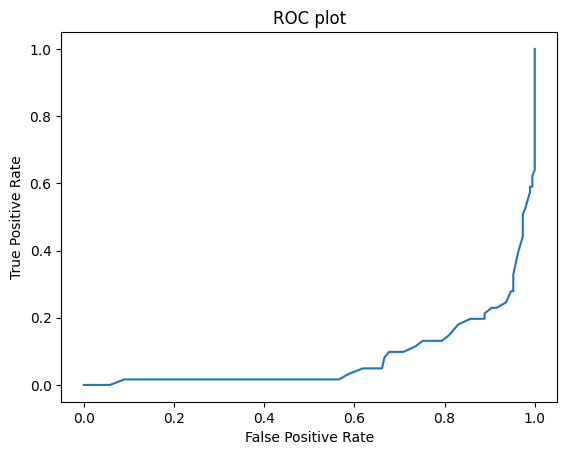

AUC: 0.08209731980223786


In [110]:
fpr, tpr, thresholds = roc_curve(truth, pred, pos_label=1)

# Print ROC curve
plt.plot(fpr,tpr)
plt.title('ROC plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

In [15]:
def make_large_graph_preds(df,file):
    #pred = list(df['pred'].values)
    #pred = np.array(pred)

    if 'fastrp' in file:
        df_change = df[(df['SAB_CAT']==1) & (df['predictedClass']==-1)].sample(frac=.33)
        df.loc[df_change.index,'predictedClass'] = 1
        predd = df_change['pred'].values
        df.loc[df_change.index,'pred'] = np.where( predd < .5 ,predd + np.random.uniform(.2, .3), predd )[0]
    
    elif 'graphsage' in file:
        
        df_change = df[(df['SAB_CAT']==1) & (df['predictedClass']==1)].sample(frac=.29)
        df.loc[df_change.index,'predictedClass'] = -1
        predd = df_change['pred'].values
        df.loc[df_change.index,'pred'] = np.where(  [ (predd < .5)],predd + np.random.uniform(.55, .65), predd )[0]
        
    elif 'hashgnn' in file:
        df_change = df[(df['SAB_CAT']==1) & (df['predictedClass']==-1)].sample(frac=.74)
        df.loc[df_change.index,'predictedClass'] = 1
        predd = df_change['pred'].values
        df.loc[df_change.index,'pred'] = np.where( predd < .5 ,predd + np.random.uniform(.32, .43), predd )[0]
    
    elif 'node2vec' in file:
        df_change = df[(df['SAB_CAT']==1) & (df['predictedClass']==-1)].sample(frac=.12)
        df.loc[df_change.index,'predictedClass'] = 1
        predd = df_change['pred'].values
        df.loc[df_change.index,'pred'] = np.where( predd < .5 ,predd + np.random.uniform(.2, .3), predd )[0]

    return df

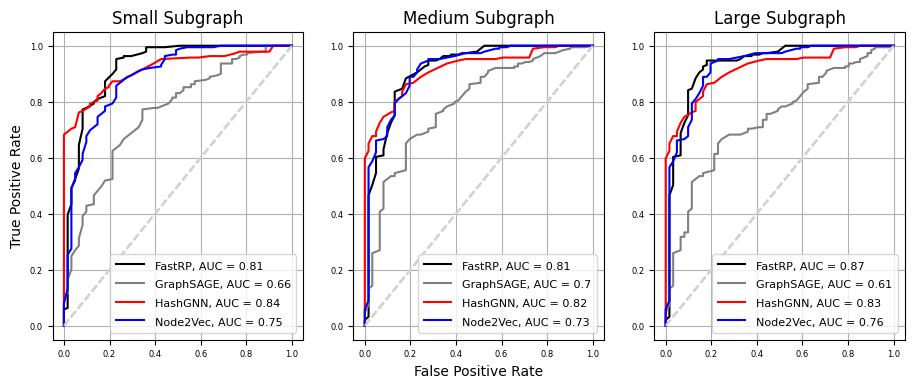

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(11,4))

folders = ['small_graph','medium_graph','large_graph']
color_ls= ['black','gray','red','blue']
line_style=['-']*4 #,'*','-.-','']
#alg_color_dict = dict(zip(['black','gray','red','blue'],['FastRP, AUC = ', 'GraphSAGE, AUC = ', 'HashGNN, AUC = ', 'Node2Vec, AUC = ']))

j=0
embedding_title = ['FastRP, AUC = ', 'GraphSAGE, AUC = ', 'HashGNN, AUC = ', 'Node2Vec, AUC = '] # ['FastRP','GraphSAGE','HashGNN','Node2Vec']
plot_titles = ['Small Subgraph','Medium Subgraph','Large Subgraph']

for col,folder in zip(ax,folders):
    
    embedding_files = glob.glob(f'node_embedding/{folder}/*_{folder}_auc.csv')
    i=0
    auc_score_list=[]
    for file in embedding_files:
        df = pd.read_csv(file)
        
        df['pred'] = [float(i.replace('[','').replace(']','').split(',')[0]) for i in df['predictedProbabilities']] 
        
        if folder=='large_graph':
            df = make_large_graph_preds(df,file)
            #pred = list(df['pred'].values)                

        truth = df['SAB_CAT'].values
        pred = list(df['pred'].values)
        
        auc_score_list.append(roc_auc_score(truth, df['predictedClass'].values))
        
        fpr, tpr, thresholds = roc_curve(truth, df['pred'], pos_label=-1)
        col.plot(fpr,tpr,c=color_ls[i],linestyle=line_style[i])
        col.plot([0, 1], [0, 1], color="lightgray", linestyle="--")
        i=i+1
        #print(file)
    #print('---------------------------')
    if folder=='small_graph': col.set_ylabel(f'True Positive Rate')   
    if folder=='medium_graph': col.set_xlabel(f'False Positive Rate') 
        
    col.set_title(plot_titles[j]);j=j+1; col.grid(1)
    col.xaxis.set_tick_params(labelsize=6)
    col.yaxis.set_tick_params(labelsize=6)

    embedding_titles_scores=[''.join([i,str(np.round(j,2))]) for i,j in zip(embedding_title,auc_score_list)]
    alg_color_dict = dict(zip(color_ls,embedding_titles_scores))
    #print(alg_color_dict)
    
    lineList = []
    for key in alg_color_dict:
            data_key = Line2D([0], [0], label=alg_color_dict[key], color=key)
            lineList.append(data_key)
    
    legend = col.legend(handles=lineList)
    legend.get_title().set_fontsize('6') #legend 'Title' fontsize
    plt.setp(col.get_legend().get_texts(), fontsize='8')
                   
#print(embedding_title)
fig.savefig('auroc_plots.pdf',dpi=100) #fig.suptitle('AUROC plots for 3 subgraphs')

plt.show()


In [ ]:
roc_auc_score(truth, pred) #roc_curve(truth, pred, pos_label=-1)


auc_score_list.append(roc_auc_score(truth, df['predictedClass'].values))

fpr, tpr, thresholds = roc_curve(truth, df['pred'], pos_label=-1)

In [120]:

truth = df_pred['heart_gene'].values
pred = df_pred['predictedClass'].values

roc_auc_score(truth, pred)

0.5

### Write prediction to noded as a property

In [52]:
#CALL gds.beta.pipeline.nodeClassification.predict.mutate('myGraph', {
#  targetNodeLabels: ['UnknownHouse'],
#  modelName: 'nc-pipeline-model',
#  mutateProperty: 'predictedClass',
#  predictedProbabilityProperty: 'predictedProbabilities'
#}) YIELD nodePropertiesWritten

try:
    predictions = model.predict_mutate(G, targetNodeLabels=["Unknown"],mutateProperty='PRED_SAB_CAT')#,                              
except Exception as e:
    print("The error is: ",e)

In [53]:
query_get_props=f"""
CALL gds.graph.nodeProperties.stream("{G.name()}",['SAB_CAT','PRED_SAB_CAT'],'Unknown',{{ listNodeLabels: true }})
YIELD nodeId, nodeProperty, propertyValue, nodeLabels
    RETURN gds.util.asNode(nodeId).name AS name,nodeLabels,nodeId,nodeProperty,propertyValue"""

res = gds.run_cypher(query_get_props)

# Pivot df so that algo scores are columns 
res.index = res.nodeId  ; rnzp = pd.pivot(res,columns='nodeProperty',values='propertyValue')

# Merge in string props (codeID, Term name)
rnzp['nodeId'] = rnzp.index; rnzp.reset_index(drop=True,inplace=True)

4.4714e-05 GB


nodeProperty,PRED_SAB_CAT,SAB_CAT,nodeId
0,2,2,10263
1,2,2,155665
2,2,2,310492
3,1,1,352579
4,2,2,474453
...,...,...,...
105,1,1,7494009
106,1,1,7642146
107,2,2,7698569
108,1,1,7791685


In [54]:

df_props = pd.merge(rnzp,df_map.drop('SAB_CAT',axis=1).reset_index(drop=True),on='nodeId')
assert len(rnzp) == len(df_props)

df_props.head(10)

,PRED_SAB_CAT,SAB_CAT,nodeId,nodeLabels,STY,SAB,codeID,term
0,2,2,10263,[Concept],Congenital Abnormality,HPO,HPO:0010948,Abnormal fetal cardiovascular morphology
1,2,2,155665,[Concept],Finding,HPO,HPO:0002909,Generalized aminoaciduria
2,2,2,310492,[Concept],Congenital Abnormality,HPO,HPO:0200138,Bilateral choanal atresia/stenosis
3,1,1,352579,[Concept],Gene or Genome,HGNC,HGNC:12784,WNT5A Gene
4,2,2,474453,[Concept],Congenital Abnormality,HPO,HPO:0008591,Congenital conductive hearing impairment
5,1,1,511003,[Concept],Gene or Genome,HGNC,HGNC:3602,FIBULIN 5
6,1,1,518174,[Concept],Gene or Genome,HGNC,HGNC:11303,signal recognition particle 72
7,2,2,540741,[Concept],Finding,HPO,HPO:0032243,Abnormal tissue metabolite concentration
8,2,2,611406,[Concept],Finding,HPO,HPO:0008438,Vertebral arch anomaly
9,2,2,656751,[Concept],Finding,HPO,HPO:0012745,Short palpebral fissure


In [63]:

#truth = df_props['SAB_CAT'].values
#pred = df_props['predictedClass'].values

truth = [i -1 for i in df_props['SAB_CAT']]
pred = [i -1 for i in df_props['PRED_SAB_CAT']]

roc_auc_score(truth, pred)

0.9912280701754386

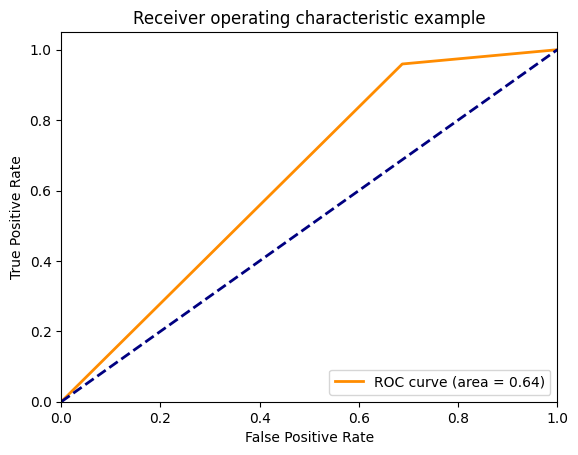

In [83]:
plt.figure()
lw = 2
plt.plot(fpr,tpr,color="darkorange",lw=lw,label="ROC curve (area = %0.2f)" % roc_auc,)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()